## Simulador de Recorridos ciclistas

### Importamos librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from keras.models import load_model
import pickle
import time

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import display
from IPython.core.display import HTML
import math as mt
py.offline.init_notebook_mode(connected=True)

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Tenemos que decidir si queremos hacer una simulación comparativa contra un resultado nuestro o contra un GPX "standar",
#ya que se encuentran en distinto fichero. Con nuestros ficheros podemos realizar comparativas exhaustivas, mientras
#que con los datos publicos esa posibilidad no existe.

#Tramos propios con datos de potencia, tiempo, etc... 
#path = '../Entrenamientos/Procesado_Tramos.xlsx'

#Tramos publicos sin datos de potencia, tiempo, etc... 
path = '../Entrenamientos/Procesado_Tramos_simulacion.xlsx'
df = pd.read_excel(path)

### Filtramos datos

In [3]:
#Listamos las pruebas que contiene el fichero
df["prueba"].unique()

array(['xxxxxxxx_LEVS_195_90_R_E.gpx'], dtype=object)

In [4]:
#Eliminar las filas que no tienen datos y seleccionamos la prueba que queremos simular
df = df[df["porc"]!=np.inf]

#En caso de que el fichero de entrada contenga más de una prueba, hay que seleccionar cual queremos simular
#df = df[df["prueba"]=="20180429_LEMG_195_90_R_C.gpx"]

In [5]:
#Se revisa que no existen datos anómalos, como +-inf por ejemplo
df.describe()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum
count,84.000000,84.000000,84.000000,84.0,84.0,84.000000,84.0,84.000000,84.000000,84.000000
mean,41.500000,1220.797619,1252.880952,0.0,0.0,507.744281,0.0,-0.587996,-0.047731,19509.435551
std,24.392622,777.046195,781.656619,0.0,0.0,693.744429,0.0,5.336408,1.819731,12154.558566
min,0.000000,0.000000,25.000000,0.0,0.0,12.158278,0.0,-9.954147,-4.645913,329.544198
25%,20.750000,529.750000,609.500000,0.0,0.0,25.516494,0.0,-4.099877,-0.565377,9742.611994
50%,41.500000,1235.500000,1266.000000,0.0,0.0,145.726222,0.0,-1.248373,0.001432,19614.673821
75%,62.250000,1779.000000,1797.500000,0.0,0.0,784.964079,0.0,2.888754,0.363841,27829.260059
max,83.000000,2663.000000,2695.000000,0.0,0.0,3454.663686,0.0,9.997376,4.950157,42624.028333


In [6]:
#Se revisa que todas las columnas contienen los datos que le corresponde
df.head()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,prueba
0,0,0,25,0,0,344.041550,0,3.492273,1.596116,329.544198,xxxxxxxx_LEVS_195_90_R_E.gpx
1,1,25,26,0,0,13.567297,0,1.574548,-0.218832,344.041550,xxxxxxxx_LEVS_195_90_R_E.gpx
2,2,26,37,0,0,168.993513,0,1.731397,0.371159,509.985494,xxxxxxxx_LEVS_195_90_R_E.gpx
3,3,37,38,0,0,17.331806,0,1.575208,-0.067596,526.602360,xxxxxxxx_LEVS_195_90_R_E.gpx
4,4,38,41,0,0,48.498332,0,3.407638,0.074144,579.260182,xxxxxxxx_LEVS_195_90_R_E.gpx


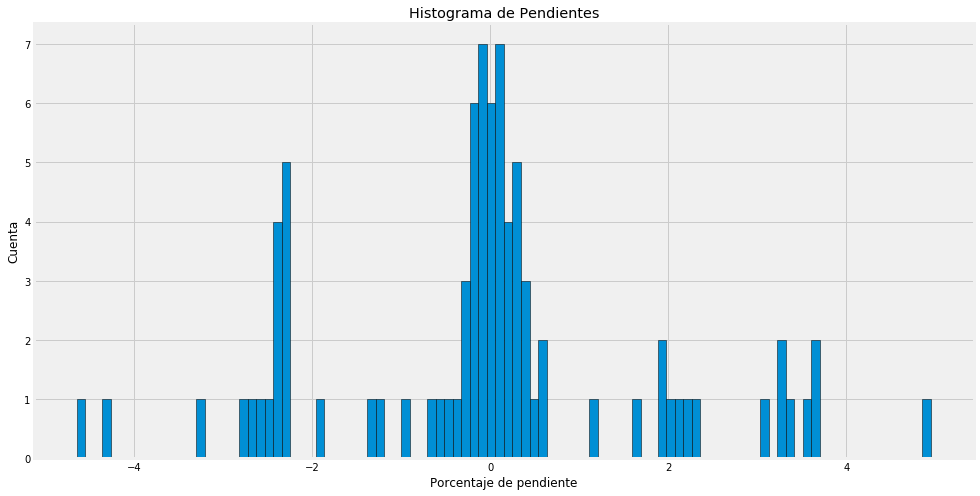

In [7]:
#Revisamos las pendientes de la prueba con el objetivo de identificar datos incoherentes

plt.figure(figsize = (15,8))
plt.hist(df['porc'],bins=100, edgecolor ='k')
plt.title('Histograma de Pendientes')
plt.xlabel('Porcentaje de pendiente')
plt.ylabel('Cuenta')
plt.show()

Vemos que la mayoría de tramos están centrados en porcentajes cercanos a 0, aunque también hay varios tramos de subidas y bajadas

## A modo de recordatorio y por su especial importancia a la hora de ejecutar la simulación, dejamos el código de la sigmoide de potencia. Más detalles de como utilizarla se pueden encontrar en la Memoria

In [8]:
def graph(pot_min, pot_max, ff_1, ff_2):
    porc = np.arange(-10,10,0.5)

    potencia = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))
    potencia_min = pot_min+(pot_max-25-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))
    potencia_max = pot_min+25+(pot_max-pot_min-25)/(1+ff_1*np.e**(ff_2*porc*-1))

    trace0 = go.Scatter(        
            x=porc,
            y=potencia,
            mode='lines',
            name='Potencia_obj')

    trace1 = go.Scatter(        
            x=porc,
            y=potencia_min,
            mode='lines',
            name='Potencia_min')

    trace2 = go.Scatter(        
            x=porc,
            y=potencia_max,
            mode='lines',
            name='Potencia_max')




    layout = go.Layout(title='Sigmoide de potencia')

    data = [trace0, trace1, trace2]

    fig = dict(data=data, layout=layout)

    py.offline.iplot(fig)

pot_min_value=widgets.IntSlider(min=40,max=100,step=5, value=65)
pot_max_value=widgets.IntSlider(min=250,max=300,step=5, value=285)
ff_1_value=widgets.FloatSlider(min=0.1,max=1,step=0.1, value=0.6)
ff_2_value=widgets.FloatSlider(min=0.1,max=1,step=0.1, value=0.35)
    
widgets.interact(graph, pot_min=pot_min_value, pot_max=pot_max_value, ff_1=ff_1_value, ff_2=ff_2_value)



interactive(children=(IntSlider(value=65, description='pot_min', min=40, step=5), IntSlider(value=285, descrip…

<function __main__.graph(pot_min, pot_max, ff_1, ff_2)>

In [9]:
#Prueba iterando en cada tramo con intervalos aleatorios con el modelo desarrollado CON TENSORFLOW (PRIMERA PASADA)

#Almacenamos la hora de inicio para evaluar el tiempo que tarda en ejecutar
start_time = time.time()

#Cargamos los dos modelos con los que vamos a trabajar
model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))

#Inicializamos las variables de control del flujo de ejecución
resultados = []

fail = 0 #Contador de simulaciones fallidas
exito = 0 #Contador de simulaciones correctas
num_pruebas = 50 #Número de éxitos para finalizar la simulación
fi = 0 #Variable para iterar

#Las siguientes variables se rellenan a criterio del entrenador o de quien use esta simulación
potencia_objetivo = 210
#pot_min = 65
#pot_max = 285
#ff_1 = 0.6
#ff_2 = 0.35

#Probamos a coger los valores de la selección de la sigmoide de la celda anterior
pot_min = pot_min_value.value
pot_max = pot_max_value.value
ff_1 = ff_1_value.value
ff_2 = ff_2_value.value


#Repetimos la simulación de pruebas hasta que tenemos un número de exitos concreto
while exito < num_pruebas:
    if (fi % 10) == 0:
        print('Empezamos la prueba %d, llevamos %d exitos y %d fracasos' %(fi,exito,fail))
        print("--- %s seconds ---" % (time.time() - start_time))
    
    #Reiniciamos la variables para acumular cada prueba
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    bins_potencias = [0] * 30
    #Simulamos cada tramo de la prueba
    while i < len(df):
        
        #Recuperamos el porcentaje de la pendiente, el viento y la distancia
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
   
    
        #Asignamos la potencia inicial según la sigmoide que se puede consultar en ../Machine Learning/Warm-Start.ipynb
        #Adicionalmente introducimos un factor de variabilidad basado en el viento aparente (>0 si viento en contra y viceversa)           
        
        if viento<0:
            min_random = (viento/2)-1
            max_random = abs(viento**2)+1
        else:
            max_random = (viento/2)+1
            min_random = (-1*viento**2)-1
            
        potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))*(np.random.randint(min_random,max_random)+100)/100
        #potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))+np.random.randint(-100,100)
        potencia_min = pot_min+(pot_max-50-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))
        potencia_max = pot_min+50+(pot_max-pot_min-50)/(1+ff_1*np.e**(ff_2*porc*-1))
                                            
        if potencia_aux>potencia_max:
            potencia = potencia_max
        elif potencia_aux<potencia_min:
            potencia = potencia_min
        else:
            potencia = potencia_aux
        
        
        
        #Utilizamos el modelo de normalización entrenado para ajustar los datos de entrada
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        #Utilizamos el modelo de Tensor Flow para predecir la velocidad media de ese tramo
        velocidad = model_TF.predict(input_model)[0]
        
        #Con la velocidad del paso anterior y la distancia del tramo, calculamos el tiempo necesario para recorrerlo
        nuevo_tiempo = distancia/(velocidad/3.6)
        #Almacenamos la información del paso actual
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        #Acumulamos la potencia y el tiempo para evaluar el resultado final y determinar si es éxito o no, y con que tiempo total
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        #acumulamos el tiempo que se pasa en cada agrupacion de potencias
        bins_potencias[int(potencia/10)] =bins_potencias[int(potencia/10)] + nuevo_tiempo[0]
        
        i += 1
    
    potencia_media = potencia_acum/tiempo_acum
    
    #Marcamos las salidas con dos digitos
    #X0  exito
    #X1 Fuera de umbral de tolerancia
    #1X Mas de 20min en zona de alta potencia (Criterio de negocio)
    
    salida = 0
    #Si la potencia queda fuera de intervalos viables, no se considera como exito
    #Nos quedamos con +/-5w sobre la potencia objetivo para luego seleccionar las mejores distribuciones de potencia
    if (potencia_media < potencia_objetivo-5) or (potencia_media > potencia_objetivo+5):
        salida = salida+1
    #Se determina en este caso, que el competidor no puede pasar más de 20min en potencias superiores a 250w    
    if sum(bins_potencias[-5:])>1200:
        salida = salida+10

    
    print("Intento %d con potencia media %d, tiempo %d y salida %d" %(fi, potencia_media, tiempo_acum, salida))
        
    #Evaluamos el exito si salida==0   
    if (salida == 0):
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        #Contamos las simulaciones consideradas sin exito
        fail +=1
        print("Tiempo por encima de de 250w:", sum(bins_potencias[-5:]))
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos favorables: %d' %(len(resultados)))

Empezamos la prueba 0, llevamos 0 exitos y 0 fracasos
--- 1.118880271911621 seconds ---
Intento 0 con potencia media 211, tiempo 5123 y salida 0
Intento 1 con potencia media 210, tiempo 5136 y salida 0
Intento 2 con potencia media 209, tiempo 5139 y salida 0
Intento 3 con potencia media 212, tiempo 5115 y salida 0
Intento 4 con potencia media 209, tiempo 5136 y salida 0
Intento 5 con potencia media 209, tiempo 5137 y salida 0
Intento 6 con potencia media 211, tiempo 5121 y salida 10
Tiempo por encima de de 250w: 1357.538314819336
Intento 7 con potencia media 211, tiempo 5118 y salida 0
Intento 8 con potencia media 210, tiempo 5132 y salida 0
Intento 9 con potencia media 210, tiempo 5127 y salida 0
Empezamos la prueba 10, llevamos 9 exitos y 1 fracasos
--- 2.1186962127685547 seconds ---
Intento 10 con potencia media 210, tiempo 5128 y salida 0
Intento 11 con potencia media 210, tiempo 5135 y salida 0
Intento 12 con potencia media 210, tiempo 5140 y salida 0
Intento 13 con potencia media

Intento 90 con potencia media 210, tiempo 5131 y salida 0
Intento 91 con potencia media 210, tiempo 5137 y salida 0
Intento 92 con potencia media 210, tiempo 5125 y salida 10
Tiempo por encima de de 250w: 1204.8476104736328
Intento 93 con potencia media 210, tiempo 5141 y salida 0
Intento 94 con potencia media 212, tiempo 5114 y salida 0
Intento 95 con potencia media 210, tiempo 5123 y salida 10
Tiempo por encima de de 250w: 1277.3888244628906
Intento 96 con potencia media 212, tiempo 5114 y salida 10
Tiempo por encima de de 250w: 1320.9688720703125
Intento 97 con potencia media 210, tiempo 5126 y salida 0
---Total time: 10.54828405380249 seconds ---
Casos descartados: 48
Casos favorables: 50


In [10]:
#Creamos DataFrame y renombramos las columnas
ds = pd.DataFrame(resultados)
ds.columns = ['intento','pwr','secs','list']
ds.head()

,intento,pwr,secs,list
0,0,211.554413,5123.538086,"[[0, 207.49641867574059, 26.563322, 344.041550..."
1,1,210.306992,5136.770508,"[[0, 227.15109711377377, 27.805597, 344.041550..."
2,2,209.310638,5139.566895,"[[0, 217.3237578947572, 27.184458, 344.0415503..."
3,3,212.277100,5115.597656,"[[0, 217.3237578947572, 27.184458, 344.0415503..."
4,4,209.830872,5136.205078,"[[0, 215.6858680249211, 27.080935, 344.0415503..."


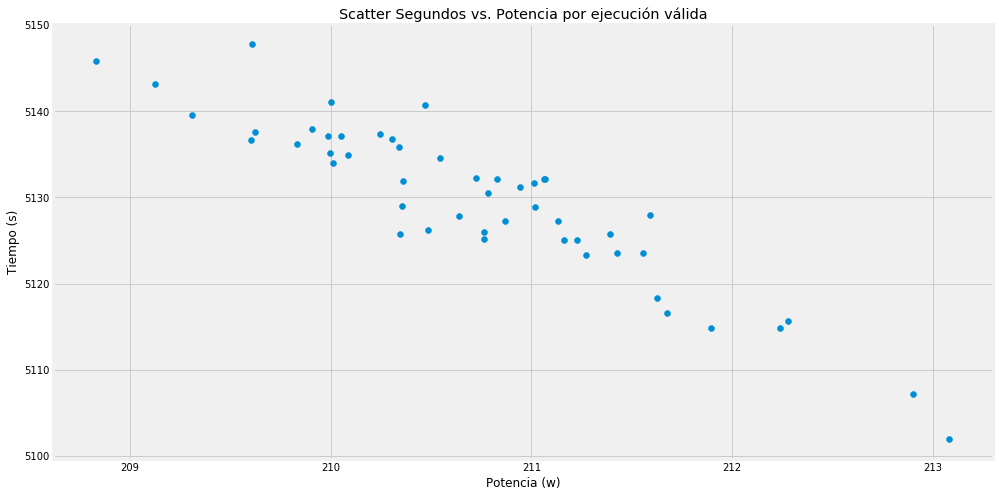

In [11]:
plt.figure(figsize = (15,8))
plt.scatter(ds['pwr'],ds['secs'])
plt.title('Scatter Segundos vs. Potencia por ejecución válida')
plt.xlabel('Potencia (w)')
plt.ylabel('Tiempo (s)')
plt.show()

En el scatter ya se ve con la misma potencia media tenemos distintos tiempos de finalización y viceversa

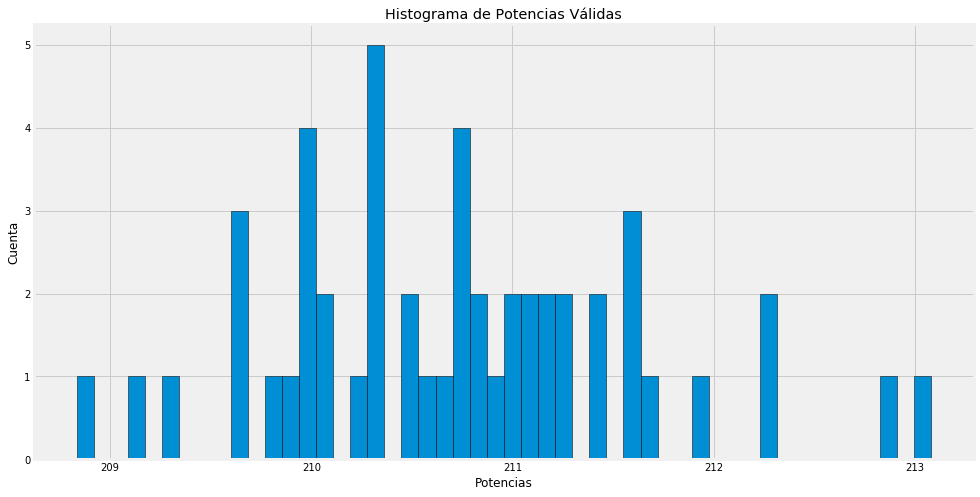

In [12]:
plt.figure(figsize = (15,8))
plt.hist(ds['pwr'],bins=50, edgecolor ='k')
plt.title('Histograma de Potencias Válidas')
plt.xlabel('Potencias')
plt.ylabel('Cuenta')
plt.show()

Histograma de potencias validas para la simulación

In [13]:
#Pintamos el mejor resultado
a = ds.groupby(['intento'])['secs'].agg('sum').sort_values(ascending=True)
mejor_tiempo = a[:1].max()
mejor_tiempo

5101.8876953125

In [14]:
#Nos quedamos con los XX mejores resultados para ser analizdos en Tableau
ganadores = pd.DataFrame(ds[ds['secs']==a[:25].max()][['intento','list']])

#Nos quedamos con el mejor resultado para inicializar las constantes en la segunda vuelta
mejor = pd.DataFrame(ds[ds['secs']==a[:1].max()][['intento','list']])
df_mejor = pd.DataFrame(mejor.values[0][1])
df_mejor.columns =["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]
df_mejor['Intento'] = mejor.values[0][0]

In [15]:
#Agregamos las características de cada tramo al df de ganadores y sacamos el resultado a Excel
for i in range(len(ganadores)):
    if i == 0:
        df_ganador = pd.DataFrame(ganadores.values[i][1])
        df_ganador.columns =["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]
        df_ganador['Intento'] = ganadores.values[i][0]
    else:
        df_aux = pd.DataFrame(ganadores.values[i][1])
        df_aux.columns =["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]
        df_aux['Intento'] = ganadores.values[i][0]
        df_ganador = df_ganador.append([df_aux])
        del df_aux
df_ganador.to_excel('res_sim.xlsx')
df_ganador.head()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,214.047978,26.977415,344.041550,45.910610,1.596116,3.492273,90
1,1,198.514554,34.898392,13.567297,1.399556,-0.218832,1.574548,90
2,2,204.759667,32.347630,168.993513,18.807457,0.371159,1.731397,90
3,3,198.551019,34.141304,17.331806,1.827537,-0.067596,1.575208,90
4,4,196.891979,33.526680,48.498332,5.207613,0.074144,3.407638,90


In [16]:
df_ganador.describe()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.0
mean,41.500000,199.093910,33.539088,507.744281,61.085938,-0.047731,-0.587996,90.0
std,24.392622,30.741924,6.687234,693.744429,87.779101,1.819731,5.336408,0.0
min,0.000000,110.926675,17.322487,12.158278,1.338178,-4.645913,-9.954147,90.0
25%,20.750000,186.114699,32.025316,25.516494,2.792548,-0.565377,-4.099877,90.0
50%,41.500000,201.950996,33.549355,145.726222,16.078275,0.001432,-1.248373,90.0
75%,62.250000,213.818867,35.838482,784.964079,76.043064,0.363841,2.888754,90.0
max,83.000000,268.693264,48.233925,3454.663686,344.280548,4.950157,9.997376,90.0


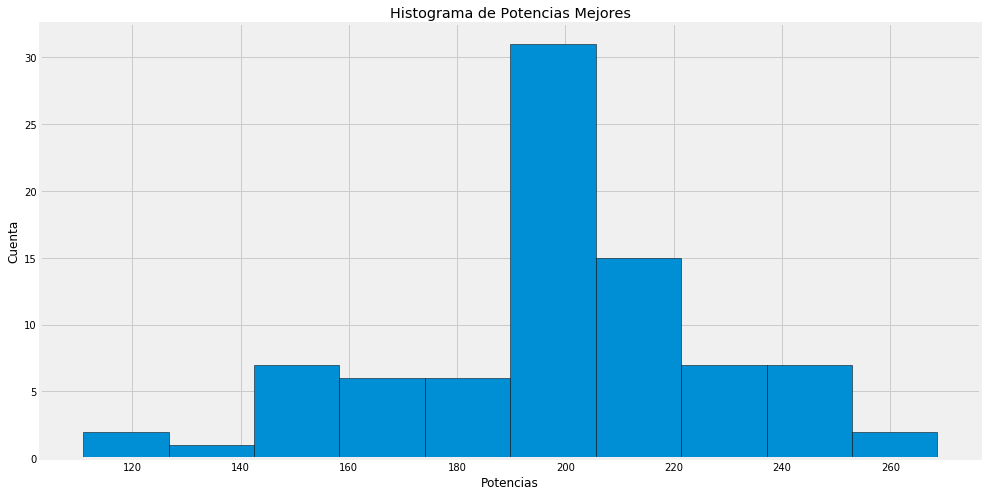

In [17]:
plt.figure(figsize = (15,8))
plt.hist(df_ganador['Potencia'], edgecolor ='k')
plt.title('Histograma de Potencias Mejores')
plt.xlabel('Potencias')
plt.ylabel('Cuenta')
plt.show()

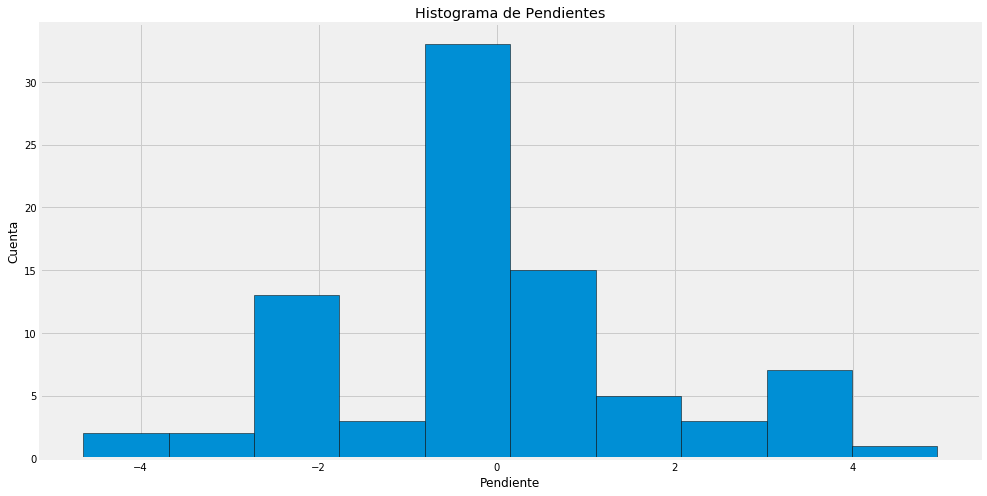

In [18]:
plt.figure(figsize = (15,8))
plt.hist(df_ganador['Pendiente'], edgecolor ='k')
plt.title('Histograma de Pendientes')
plt.xlabel('Pendiente')
plt.ylabel('Cuenta')
plt.show()

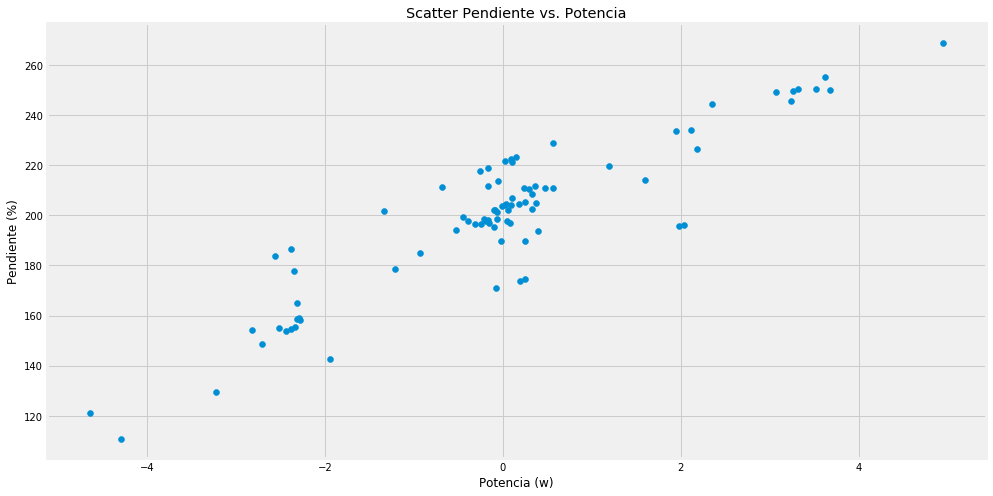

In [19]:
plt.figure(figsize = (15,8))
plt.scatter(df_ganador['Pendiente'],df_ganador['Potencia'])
plt.title('Scatter Pendiente vs. Potencia')
plt.xlabel('Potencia (w)')
plt.ylabel('Pendiente (%)')
plt.show()

La distribución de potencia es acorde a lo esperado. Vamos a ver como se comporta con respecto al viento

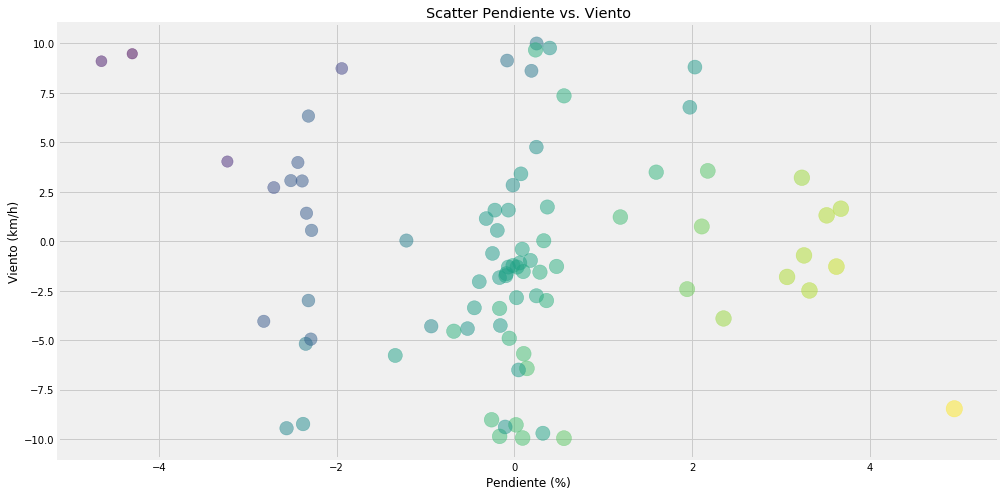

In [20]:
plt.figure(figsize = (15,8))
plt.scatter(df_ganador['Pendiente'],df_ganador['Viento'], c=df_ganador['Potencia'],s=df_ganador['Potencia'], alpha=0.5)
plt.title('Scatter Pendiente vs. Viento')
plt.xlabel('Pendiente (%)')
plt.ylabel('Viento (km/h)')
plt.show()

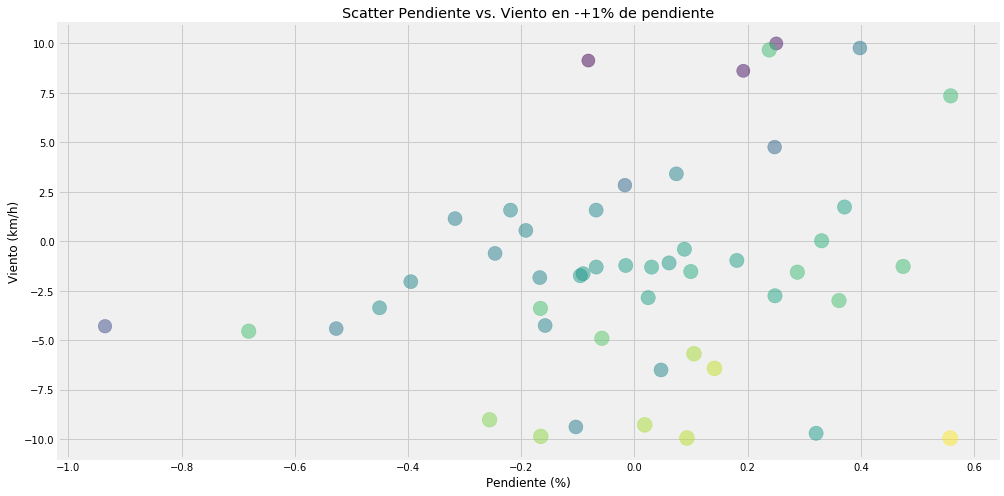

In [21]:
plt.figure(figsize = (15,8))
df_ganador_filtrado = df_ganador[(df_ganador['Pendiente']>-1) & (df_ganador['Pendiente']<1)]
plt.scatter(df_ganador_filtrado['Pendiente'].values,df_ganador_filtrado['Viento'].values, c=df_ganador_filtrado['Potencia'].values,
           s=df_ganador_filtrado['Potencia'].values, alpha=0.5)
plt.title('Scatter Pendiente vs. Viento en -+1% de pendiente')
plt.xlabel('Pendiente (%)')
plt.ylabel('Viento (km/h)')
plt.show()

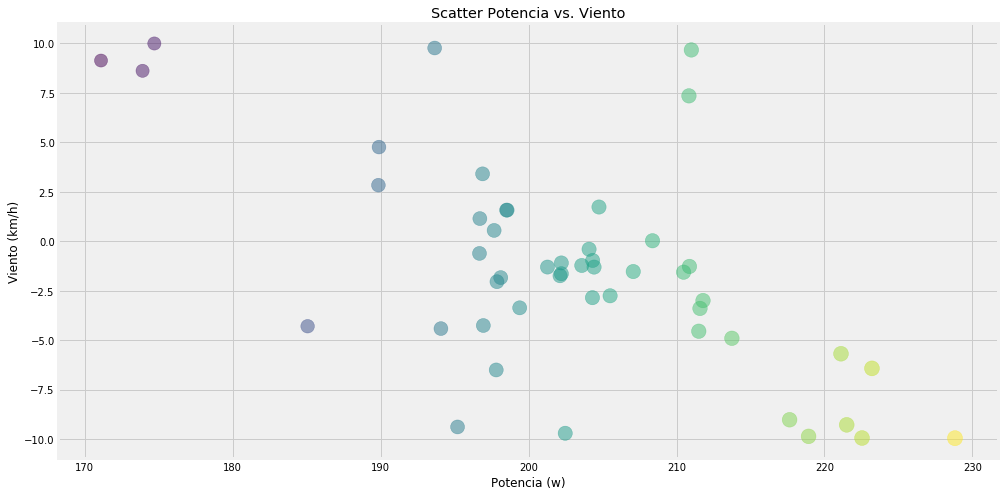

In [22]:
plt.figure(figsize = (15,8))
plt.scatter(df_ganador_filtrado['Potencia'].values,df_ganador_filtrado['Viento'].values, c=df_ganador_filtrado['Potencia'].values,
           s=df_ganador_filtrado['Potencia'].values, alpha=0.5)
plt.title('Scatter Potencia vs. Viento')
plt.xlabel('Potencia (w)')
plt.ylabel('Viento (km/h)')
plt.show()

Como podemos ver, la potencia aumenta según tenemos más viento a favor, lo cual es lógico si recordamos que el viento suma a la velocidad y se eleva al cuadrado

In [23]:
#Juntamos el resultado de la simulación con el recorrido original a efectos de comparativa posterior en Tableau
df_input = df[['tramo','pwr','spd','dist','time_seg','porc','viento_aparente']]
df_input.columns =["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]
df_input['Intento'] = 'Original'
df_input.append([df_ganador]).to_excel('res_sim_ori.xlsx')
df_input.head()

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,0,0,344.041550,0,1.596116,3.492273,Original
1,1,0,0,13.567297,0,-0.218832,1.574548,Original
2,2,0,0,168.993513,0,0.371159,1.731397,Original
3,3,0,0,17.331806,0,-0.067596,1.575208,Original
4,4,0,0,48.498332,0,0.074144,3.407638,Original


In [24]:
potencias_medias = df_mejor.groupby(['Tramos'])['Potencia'].agg('mean')

#### Posible mejora del modelo, inicializando la potencia de cada tramo con el mejor resultado de la primera simulación

In [25]:
#CON TENSORFLOW (SEGUNDA PASADA)
#Almacenamos la hora de inicio para evaluar el tiempo que tarda en ejecutar
start_time = time.time()

#Utilizamos los modelos que se emplearon en la primera pasada* es obviamente necesario ejecutar las celdas en orden
#model_TF = load_model('../RNN/TF_Tramos_2.model')
#model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))

#Inicializamos las variables de control del flujo de ejecución
resultados = []

fail = 0 #Contador de simulaciones fallidas
exito = 0 #Contador de simulaciones correctas
num_pruebas = 25 #Número de éxitos para finalizar la simulación
fi = 0 #Variable para iterar

#Utilizamos las mismas constantes que se emplearon en la primera pasada* es obviamente necesario ejecutar las celdas en orden
#potencia_objetivo = 220
#pot_min = 60
#pot_max = 275
#ff_1 = 0.3
#ff_2 = 0.7

print("Tiempo a mejorar: %d" %mejor_tiempo)

#Repetimos la simulación de pruebas hasta que tenemos un número de exitos concreto
while exito < num_pruebas:
    if (fi % 10) == 0:
        print('Empezamos la prueba %d, llevamos %d exitos y %d fracasos' %(fi,exito,fail))
        print("--- %s seconds ---" % (time.time() - start_time))
    
    #Reiniciamos la variables para acumular cada prueba
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    bins_potencias = [0] * 30
    
    #Simulamos cada tramo de la prueba
    while i < len(df):
        
        #Recuperamos el porcentaje de la pendiente, el viento y la distancia
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
        
        #Asignamos la potencia inicial según la sigmoide que se puede consultar en ../Machine Learning/Warm-Start.ipynb
        #Adicionalmente introducimos un factor de variabilidad basado en el viento aparente (>0 si viento en contra y viceversa)           
        
        if viento<0:
            min_random = (viento/4)-1
            max_random = abs(viento*3)+1
        else:
            max_random = (viento/4)+1
            min_random = (-1*viento*3)-1
        
        
        potencia_aux = potencias_medias[i]*(np.random.randint(min_random,max_random)+100)/100
        
        #Con el objetivo de complemplar mayor espectro, abrimos los intervalos 5w para probar
        potencia_min = pot_min+(pot_max-50-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))-5
        potencia_max = pot_min+50+(pot_max-pot_min-50)/(1+ff_1*np.e**(ff_2*porc*-1))+5

        
        if potencia_aux>potencia_max:
            potencia = potencia_max
        elif potencia_aux<potencia_min:
            potencia = potencia_min
        else:
            potencia = potencia_aux
    
        #print(pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1)),potencias_medias[i], potencia)
        #input("sigue")

        
        
        #Utilizamos el modelo de normalización entrenado para ajustar los datos de entrada
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        #Utilizamos el modelo de Tensor Flow para predecir la velocidad media de ese tramo
        velocidad = model_TF.predict(input_model)[0]
        
        #Con la velocidad del paso anterior y la distancia del tramo, calculamos el tiempo necesario para recorrerlo
        nuevo_tiempo = distancia/(velocidad/3.6)
        #Almacenamos la información del paso actual
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        #Acumulamos la potencia y el tiempo para evaluar el resultado final y determinar si es éxito o no, y con que tiempo total
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        #acumulamos el tiempo que se pasa en cada agrupacion de potencias
        bins_potencias[int(potencia/10)] =bins_potencias[int(potencia/10)] + nuevo_tiempo[0]
        
        i += 1
    
    
    
    potencia_media = potencia_acum/tiempo_acum
    
        #Marcamos las salidas con dos digitos
    #0  exito
    #XX1 Fuera de umbral de tolerancia
    #X1X Mas de 20min en zona de alta potencia (Criterio de negocio)
    #1XX No mejoramos tiempo de referencia
    
    
    salida = 0
    #Si la potencia queda fuera de intervalos viables, no se considera como exito
    #Nos quedamos con +/-5w sobre la potencia objetivo para luego seleccionar las mejores distribuciones de potencia
    if (potencia_media < potencia_objetivo-5) or (potencia_media > potencia_objetivo+5):
        salida = salida+1
    #Se determina en este caso, que el competidor no puede pasar más de 20min en potencias superiores a 250w    
    if sum(bins_potencias[-5:])>1200:
        salida = salida+10
    #Si el tiempo final es superior al que necesitamos mejorar, no se considera éxito
    if tiempo_acum[0]>mejor_tiempo:
        salida = salida+100

       
    print("Intento %d con potencia media %d, tiempo %d y salida %d" %(fi, potencia_media, tiempo_acum, salida))
    
    #Evaluamos el exito si salida==0
    if (salida==0):
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        #Contamos las simulaciones consideradas sin exito
        fail +=1
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos favorables: %d' %(len(resultados)))

Tiempo a mejorar: 5101
Empezamos la prueba 0, llevamos 0 exitos y 0 fracasos
--- 0.0010128021240234375 seconds ---
Intento 0 con potencia media 212, tiempo 5112 y salida 110
Intento 1 con potencia media 211, tiempo 5116 y salida 100
Intento 2 con potencia media 211, tiempo 5114 y salida 100
Intento 3 con potencia media 212, tiempo 5116 y salida 100
Intento 4 con potencia media 211, tiempo 5114 y salida 110
Intento 5 con potencia media 211, tiempo 5124 y salida 110
Intento 6 con potencia media 210, tiempo 5133 y salida 100
Intento 7 con potencia media 211, tiempo 5128 y salida 110
Intento 8 con potencia media 211, tiempo 5116 y salida 110
Intento 9 con potencia media 209, tiempo 5132 y salida 110
Empezamos la prueba 10, llevamos 0 exitos y 10 fracasos
--- 0.9747314453125 seconds ---
Intento 10 con potencia media 210, tiempo 5129 y salida 110
Intento 11 con potencia media 210, tiempo 5131 y salida 100
Intento 12 con potencia media 211, tiempo 5127 y salida 100
Intento 13 con potencia med

Intento 120 con potencia media 211, tiempo 5109 y salida 110
Intento 121 con potencia media 211, tiempo 5124 y salida 110
Intento 122 con potencia media 211, tiempo 5129 y salida 110
Intento 123 con potencia media 209, tiempo 5139 y salida 110
Intento 124 con potencia media 211, tiempo 5119 y salida 110
Intento 125 con potencia media 210, tiempo 5129 y salida 100
Intento 126 con potencia media 210, tiempo 5137 y salida 110
Intento 127 con potencia media 211, tiempo 5115 y salida 100
Intento 128 con potencia media 211, tiempo 5113 y salida 110
Intento 129 con potencia media 210, tiempo 5131 y salida 100
Empezamos la prueba 130, llevamos 0 exitos y 130 fracasos
--- 12.896417379379272 seconds ---
Intento 130 con potencia media 210, tiempo 5140 y salida 100
Intento 131 con potencia media 212, tiempo 5108 y salida 110
Intento 132 con potencia media 211, tiempo 5114 y salida 100
Intento 133 con potencia media 211, tiempo 5115 y salida 110
Intento 134 con potencia media 209, tiempo 5129 y sal

Empezamos la prueba 240, llevamos 0 exitos y 240 fracasos
--- 23.767770528793335 seconds ---
Intento 240 con potencia media 211, tiempo 5118 y salida 110
Intento 241 con potencia media 210, tiempo 5130 y salida 110
Intento 242 con potencia media 209, tiempo 5141 y salida 110
Intento 243 con potencia media 212, tiempo 5119 y salida 100
Intento 244 con potencia media 211, tiempo 5119 y salida 110
Intento 245 con potencia media 211, tiempo 5127 y salida 110
Intento 246 con potencia media 212, tiempo 5108 y salida 110
Intento 247 con potencia media 211, tiempo 5126 y salida 110
Intento 248 con potencia media 211, tiempo 5125 y salida 110
Intento 249 con potencia media 210, tiempo 5126 y salida 110
Empezamos la prueba 250, llevamos 0 exitos y 250 fracasos
--- 24.790605783462524 seconds ---
Intento 250 con potencia media 212, tiempo 5104 y salida 100
Intento 251 con potencia media 210, tiempo 5117 y salida 110
Intento 252 con potencia media 211, tiempo 5119 y salida 110
Intento 253 con poten

Intento 359 con potencia media 210, tiempo 5126 y salida 100
Empezamos la prueba 360, llevamos 0 exitos y 360 fracasos
--- 35.73840355873108 seconds ---
Intento 360 con potencia media 210, tiempo 5130 y salida 100
Intento 361 con potencia media 210, tiempo 5124 y salida 110
Intento 362 con potencia media 211, tiempo 5113 y salida 110
Intento 363 con potencia media 211, tiempo 5124 y salida 110
Intento 364 con potencia media 211, tiempo 5123 y salida 110
Intento 365 con potencia media 211, tiempo 5125 y salida 100
Intento 366 con potencia media 210, tiempo 5135 y salida 100
Intento 367 con potencia media 212, tiempo 5102 y salida 110
Intento 368 con potencia media 212, tiempo 5111 y salida 110
Intento 369 con potencia media 210, tiempo 5127 y salida 110
Empezamos la prueba 370, llevamos 0 exitos y 370 fracasos
--- 36.726069927215576 seconds ---
Intento 370 con potencia media 210, tiempo 5132 y salida 110
Intento 371 con potencia media 211, tiempo 5121 y salida 100
Intento 372 con potenc

Intento 477 con potencia media 210, tiempo 5138 y salida 110
Intento 478 con potencia media 211, tiempo 5113 y salida 110
Intento 479 con potencia media 211, tiempo 5122 y salida 100
Empezamos la prueba 480, llevamos 0 exitos y 480 fracasos
--- 47.61562442779541 seconds ---
Intento 480 con potencia media 211, tiempo 5129 y salida 100
Intento 481 con potencia media 211, tiempo 5122 y salida 110
Intento 482 con potencia media 209, tiempo 5138 y salida 100
Intento 483 con potencia media 212, tiempo 5110 y salida 100
Intento 484 con potencia media 210, tiempo 5124 y salida 110
Intento 485 con potencia media 211, tiempo 5117 y salida 100
Intento 486 con potencia media 212, tiempo 5115 y salida 110
Intento 487 con potencia media 210, tiempo 5129 y salida 110
Intento 488 con potencia media 212, tiempo 5111 y salida 110
Intento 489 con potencia media 211, tiempo 5121 y salida 110
Empezamos la prueba 490, llevamos 0 exitos y 490 fracasos
--- 48.61845660209656 seconds ---
Intento 490 con potenci

Intento 595 con potencia media 210, tiempo 5144 y salida 100
Intento 596 con potencia media 211, tiempo 5113 y salida 100
Intento 597 con potencia media 211, tiempo 5121 y salida 110
Intento 598 con potencia media 210, tiempo 5132 y salida 110
Intento 599 con potencia media 211, tiempo 5125 y salida 100
Empezamos la prueba 600, llevamos 0 exitos y 600 fracasos
--- 59.70012664794922 seconds ---
Intento 600 con potencia media 210, tiempo 5131 y salida 110
Intento 601 con potencia media 212, tiempo 5110 y salida 110
Intento 602 con potencia media 209, tiempo 5141 y salida 110
Intento 603 con potencia media 211, tiempo 5127 y salida 110
Intento 604 con potencia media 212, tiempo 5114 y salida 110
Intento 605 con potencia media 211, tiempo 5123 y salida 100
Intento 606 con potencia media 212, tiempo 5106 y salida 110
Intento 607 con potencia media 210, tiempo 5135 y salida 110
Intento 608 con potencia media 212, tiempo 5113 y salida 110
Intento 609 con potencia media 211, tiempo 5126 y sali

Intento 712 con potencia media 209, tiempo 5144 y salida 100
Intento 713 con potencia media 210, tiempo 5130 y salida 100
Intento 714 con potencia media 211, tiempo 5126 y salida 110
Intento 715 con potencia media 212, tiempo 5112 y salida 110
Intento 716 con potencia media 210, tiempo 5142 y salida 100
Intento 717 con potencia media 212, tiempo 5104 y salida 110
Intento 718 con potencia media 212, tiempo 5114 y salida 110
Intento 719 con potencia media 212, tiempo 5104 y salida 110
Empezamos la prueba 720, llevamos 0 exitos y 720 fracasos
--- 71.82370948791504 seconds ---
Intento 720 con potencia media 213, tiempo 5101 y salida 0
Intento 721 con potencia media 210, tiempo 5129 y salida 110
Intento 722 con potencia media 210, tiempo 5130 y salida 100
Intento 723 con potencia media 210, tiempo 5136 y salida 110
Intento 724 con potencia media 212, tiempo 5116 y salida 110
Intento 725 con potencia media 211, tiempo 5122 y salida 110
Intento 726 con potencia media 209, tiempo 5138 y salida

Intento 831 con potencia media 210, tiempo 5131 y salida 110
Intento 832 con potencia media 209, tiempo 5149 y salida 100
Intento 833 con potencia media 211, tiempo 5115 y salida 100
Intento 834 con potencia media 213, tiempo 5105 y salida 110
Intento 835 con potencia media 209, tiempo 5136 y salida 110
Intento 836 con potencia media 210, tiempo 5132 y salida 110
Intento 837 con potencia media 210, tiempo 5125 y salida 110
Intento 838 con potencia media 211, tiempo 5111 y salida 110
Intento 839 con potencia media 210, tiempo 5130 y salida 100
Empezamos la prueba 840, llevamos 1 exitos y 839 fracasos
--- 84.29301595687866 seconds ---
Intento 840 con potencia media 211, tiempo 5119 y salida 110
Intento 841 con potencia media 212, tiempo 5105 y salida 100
Intento 842 con potencia media 212, tiempo 5110 y salida 110
Intento 843 con potencia media 211, tiempo 5122 y salida 110
Intento 844 con potencia media 211, tiempo 5129 y salida 110
Intento 845 con potencia media 212, tiempo 5105 y sali

Intento 949 con potencia media 210, tiempo 5139 y salida 100
Empezamos la prueba 950, llevamos 1 exitos y 949 fracasos
--- 95.34261536598206 seconds ---
Intento 950 con potencia media 211, tiempo 5118 y salida 100
Intento 951 con potencia media 210, tiempo 5135 y salida 110
Intento 952 con potencia media 212, tiempo 5109 y salida 110
Intento 953 con potencia media 211, tiempo 5117 y salida 110
Intento 954 con potencia media 210, tiempo 5138 y salida 100
Intento 955 con potencia media 212, tiempo 5104 y salida 100
Intento 956 con potencia media 213, tiempo 5109 y salida 100
Intento 957 con potencia media 210, tiempo 5132 y salida 110
Intento 958 con potencia media 212, tiempo 5105 y salida 110
Intento 959 con potencia media 212, tiempo 5125 y salida 110
Empezamos la prueba 960, llevamos 1 exitos y 959 fracasos
--- 96.3584475517273 seconds ---
Intento 960 con potencia media 212, tiempo 5115 y salida 100
Intento 961 con potencia media 213, tiempo 5090 y salida 10
Intento 962 con potencia 

Intento 1066 con potencia media 212, tiempo 5115 y salida 110
Intento 1067 con potencia media 210, tiempo 5123 y salida 110
Intento 1068 con potencia media 212, tiempo 5111 y salida 110
Intento 1069 con potencia media 211, tiempo 5118 y salida 110
Empezamos la prueba 1070, llevamos 2 exitos y 1068 fracasos
--- 107.92456889152527 seconds ---
Intento 1070 con potencia media 210, tiempo 5130 y salida 110
Intento 1071 con potencia media 210, tiempo 5125 y salida 100
Intento 1072 con potencia media 212, tiempo 5114 y salida 100
Intento 1073 con potencia media 210, tiempo 5120 y salida 110
Intento 1074 con potencia media 211, tiempo 5118 y salida 110
Intento 1075 con potencia media 212, tiempo 5109 y salida 110
Intento 1076 con potencia media 210, tiempo 5129 y salida 100
Intento 1077 con potencia media 211, tiempo 5121 y salida 100
Intento 1078 con potencia media 211, tiempo 5112 y salida 110
Intento 1079 con potencia media 212, tiempo 5105 y salida 110
Empezamos la prueba 1080, llevamos 2 

Intento 1181 con potencia media 213, tiempo 5102 y salida 110
Intento 1182 con potencia media 213, tiempo 5108 y salida 100
Intento 1183 con potencia media 210, tiempo 5133 y salida 110
Intento 1184 con potencia media 212, tiempo 5118 y salida 110
Intento 1185 con potencia media 211, tiempo 5120 y salida 100
Intento 1186 con potencia media 212, tiempo 5097 y salida 10
Intento 1187 con potencia media 210, tiempo 5131 y salida 100
Intento 1188 con potencia media 211, tiempo 5126 y salida 110
Intento 1189 con potencia media 211, tiempo 5124 y salida 110
Empezamos la prueba 1190, llevamos 2 exitos y 1188 fracasos
--- 120.62255549430847 seconds ---
Intento 1190 con potencia media 210, tiempo 5128 y salida 110
Intento 1191 con potencia media 210, tiempo 5123 y salida 100
Intento 1192 con potencia media 210, tiempo 5120 y salida 110
Intento 1193 con potencia media 208, tiempo 5143 y salida 100
Intento 1194 con potencia media 211, tiempo 5119 y salida 110
Intento 1195 con potencia media 212, t

Intento 1298 con potencia media 210, tiempo 5144 y salida 110
Intento 1299 con potencia media 211, tiempo 5111 y salida 110
Empezamos la prueba 1300, llevamos 2 exitos y 1298 fracasos
--- 133.38852167129517 seconds ---
Intento 1300 con potencia media 210, tiempo 5137 y salida 110
Intento 1301 con potencia media 210, tiempo 5124 y salida 110
Intento 1302 con potencia media 211, tiempo 5115 y salida 110
Intento 1303 con potencia media 210, tiempo 5133 y salida 100
Intento 1304 con potencia media 210, tiempo 5122 y salida 110
Intento 1305 con potencia media 210, tiempo 5137 y salida 110
Intento 1306 con potencia media 211, tiempo 5128 y salida 100
Intento 1307 con potencia media 211, tiempo 5119 y salida 110
Intento 1308 con potencia media 212, tiempo 5114 y salida 110
Intento 1309 con potencia media 212, tiempo 5110 y salida 110
Empezamos la prueba 1310, llevamos 2 exitos y 1308 fracasos
--- 134.5355405807495 seconds ---
Intento 1310 con potencia media 212, tiempo 5112 y salida 100
Inten

Intento 1412 con potencia media 210, tiempo 5126 y salida 110
Intento 1413 con potencia media 211, tiempo 5111 y salida 110
Intento 1414 con potencia media 210, tiempo 5140 y salida 100
Intento 1415 con potencia media 210, tiempo 5120 y salida 110
Intento 1416 con potencia media 211, tiempo 5121 y salida 100
Intento 1417 con potencia media 211, tiempo 5110 y salida 110
Intento 1418 con potencia media 213, tiempo 5105 y salida 110
Intento 1419 con potencia media 210, tiempo 5119 y salida 110
Empezamos la prueba 1420, llevamos 2 exitos y 1418 fracasos
--- 146.6612594127655 seconds ---
Intento 1420 con potencia media 211, tiempo 5128 y salida 100
Intento 1421 con potencia media 211, tiempo 5125 y salida 110
Intento 1422 con potencia media 211, tiempo 5114 y salida 110
Intento 1423 con potencia media 211, tiempo 5127 y salida 100
Intento 1424 con potencia media 211, tiempo 5118 y salida 110
Intento 1425 con potencia media 210, tiempo 5128 y salida 110
Intento 1426 con potencia media 210, t

Intento 1528 con potencia media 212, tiempo 5112 y salida 110
Intento 1529 con potencia media 209, tiempo 5150 y salida 100
Empezamos la prueba 1530, llevamos 3 exitos y 1527 fracasos
--- 158.02460074424744 seconds ---
Intento 1530 con potencia media 212, tiempo 5117 y salida 110
Intento 1531 con potencia media 211, tiempo 5113 y salida 110
Intento 1532 con potencia media 210, tiempo 5131 y salida 110
Intento 1533 con potencia media 211, tiempo 5120 y salida 110
Intento 1534 con potencia media 209, tiempo 5139 y salida 110
Intento 1535 con potencia media 210, tiempo 5120 y salida 110
Intento 1536 con potencia media 210, tiempo 5134 y salida 110
Intento 1537 con potencia media 210, tiempo 5143 y salida 100
Intento 1538 con potencia media 212, tiempo 5101 y salida 10
Intento 1539 con potencia media 212, tiempo 5112 y salida 100
Empezamos la prueba 1540, llevamos 3 exitos y 1537 fracasos
--- 159.060072183609 seconds ---
Intento 1540 con potencia media 210, tiempo 5137 y salida 100
Intento

Intento 1643 con potencia media 211, tiempo 5122 y salida 110
Intento 1644 con potencia media 211, tiempo 5122 y salida 100
Intento 1645 con potencia media 211, tiempo 5114 y salida 110
Intento 1646 con potencia media 211, tiempo 5132 y salida 110
Intento 1647 con potencia media 212, tiempo 5118 y salida 110
Intento 1648 con potencia media 211, tiempo 5130 y salida 110
Intento 1649 con potencia media 212, tiempo 5120 y salida 110
Empezamos la prueba 1650, llevamos 3 exitos y 1647 fracasos
--- 170.2826647758484 seconds ---
Intento 1650 con potencia media 211, tiempo 5118 y salida 110
Intento 1651 con potencia media 211, tiempo 5110 y salida 110
Intento 1652 con potencia media 213, tiempo 5101 y salida 10
Intento 1653 con potencia media 211, tiempo 5115 y salida 110
Intento 1654 con potencia media 212, tiempo 5109 y salida 110
Intento 1655 con potencia media 212, tiempo 5104 y salida 110
Intento 1656 con potencia media 210, tiempo 5125 y salida 110
Intento 1657 con potencia media 212, ti

Intento 1759 con potencia media 209, tiempo 5150 y salida 100
Empezamos la prueba 1760, llevamos 3 exitos y 1757 fracasos
--- 182.4314103126526 seconds ---
Intento 1760 con potencia media 210, tiempo 5129 y salida 100
Intento 1761 con potencia media 211, tiempo 5119 y salida 110
Intento 1762 con potencia media 211, tiempo 5123 y salida 110
Intento 1763 con potencia media 210, tiempo 5121 y salida 110
Intento 1764 con potencia media 211, tiempo 5129 y salida 110
Intento 1765 con potencia media 212, tiempo 5116 y salida 110
Intento 1766 con potencia media 210, tiempo 5119 y salida 110
Intento 1767 con potencia media 212, tiempo 5094 y salida 10
Intento 1768 con potencia media 213, tiempo 5098 y salida 10
Intento 1769 con potencia media 211, tiempo 5131 y salida 100
Empezamos la prueba 1770, llevamos 3 exitos y 1767 fracasos
--- 183.50825595855713 seconds ---
Intento 1770 con potencia media 211, tiempo 5112 y salida 100
Intento 1771 con potencia media 213, tiempo 5101 y salida 10
Intento 

Intento 1874 con potencia media 213, tiempo 5104 y salida 110
Intento 1875 con potencia media 210, tiempo 5136 y salida 100
Intento 1876 con potencia media 211, tiempo 5125 y salida 110
Intento 1877 con potencia media 210, tiempo 5124 y salida 100
Intento 1878 con potencia media 210, tiempo 5130 y salida 100
Intento 1879 con potencia media 211, tiempo 5120 y salida 110
Empezamos la prueba 1880, llevamos 3 exitos y 1877 fracasos
--- 195.49001693725586 seconds ---
Intento 1880 con potencia media 211, tiempo 5115 y salida 110
Intento 1881 con potencia media 211, tiempo 5132 y salida 110
Intento 1882 con potencia media 211, tiempo 5118 y salida 110
Intento 1883 con potencia media 211, tiempo 5120 y salida 110
Intento 1884 con potencia media 210, tiempo 5122 y salida 100
Intento 1885 con potencia media 210, tiempo 5136 y salida 100
Intento 1886 con potencia media 211, tiempo 5118 y salida 110
Intento 1887 con potencia media 210, tiempo 5129 y salida 110
Intento 1888 con potencia media 211, 

Intento 1991 con potencia media 211, tiempo 5121 y salida 110
Intento 1992 con potencia media 211, tiempo 5121 y salida 100
Intento 1993 con potencia media 211, tiempo 5118 y salida 110
Intento 1994 con potencia media 210, tiempo 5137 y salida 100
Intento 1995 con potencia media 211, tiempo 5111 y salida 110
Intento 1996 con potencia media 210, tiempo 5132 y salida 100
Intento 1997 con potencia media 211, tiempo 5123 y salida 110
Intento 1998 con potencia media 211, tiempo 5122 y salida 100
Intento 1999 con potencia media 211, tiempo 5116 y salida 110
Empezamos la prueba 2000, llevamos 3 exitos y 1997 fracasos
--- 207.69551134109497 seconds ---
Intento 2000 con potencia media 209, tiempo 5142 y salida 100
Intento 2001 con potencia media 210, tiempo 5133 y salida 100
Intento 2002 con potencia media 210, tiempo 5129 y salida 100
Intento 2003 con potencia media 211, tiempo 5115 y salida 100
Intento 2004 con potencia media 211, tiempo 5123 y salida 110
Intento 2005 con potencia media 210, 

Intento 2109 con potencia media 211, tiempo 5120 y salida 110
Empezamos la prueba 2110, llevamos 3 exitos y 2107 fracasos
--- 218.78863072395325 seconds ---
Intento 2110 con potencia media 211, tiempo 5122 y salida 100
Intento 2111 con potencia media 212, tiempo 5116 y salida 110
Intento 2112 con potencia media 211, tiempo 5112 y salida 100
Intento 2113 con potencia media 210, tiempo 5126 y salida 110
Intento 2114 con potencia media 212, tiempo 5119 y salida 110
Intento 2115 con potencia media 210, tiempo 5121 y salida 110
Intento 2116 con potencia media 211, tiempo 5122 y salida 100
Intento 2117 con potencia media 212, tiempo 5115 y salida 110
Intento 2118 con potencia media 211, tiempo 5133 y salida 100
Intento 2119 con potencia media 211, tiempo 5123 y salida 110
Empezamos la prueba 2120, llevamos 3 exitos y 2117 fracasos
--- 219.8028633594513 seconds ---
Intento 2120 con potencia media 211, tiempo 5123 y salida 110
Intento 2121 con potencia media 211, tiempo 5118 y salida 110
Inten

Intento 2224 con potencia media 212, tiempo 5110 y salida 100
Intento 2225 con potencia media 210, tiempo 5123 y salida 100
Intento 2226 con potencia media 211, tiempo 5123 y salida 100
Intento 2227 con potencia media 210, tiempo 5129 y salida 100
Intento 2228 con potencia media 209, tiempo 5141 y salida 110
Intento 2229 con potencia media 212, tiempo 5115 y salida 110
Empezamos la prueba 2230, llevamos 4 exitos y 2226 fracasos
--- 231.25230741500854 seconds ---
Intento 2230 con potencia media 213, tiempo 5097 y salida 10
Intento 2231 con potencia media 208, tiempo 5143 y salida 110
Intento 2232 con potencia media 210, tiempo 5139 y salida 110
Intento 2233 con potencia media 211, tiempo 5123 y salida 110
Intento 2234 con potencia media 211, tiempo 5110 y salida 100
Intento 2235 con potencia media 211, tiempo 5123 y salida 110
Intento 2236 con potencia media 212, tiempo 5110 y salida 110
Intento 2237 con potencia media 210, tiempo 5131 y salida 100
Intento 2238 con potencia media 210, t

Intento 2340 con potencia media 212, tiempo 5118 y salida 110
Intento 2341 con potencia media 211, tiempo 5120 y salida 100
Intento 2342 con potencia media 210, tiempo 5133 y salida 100
Intento 2343 con potencia media 210, tiempo 5131 y salida 110
Intento 2344 con potencia media 211, tiempo 5120 y salida 110
Intento 2345 con potencia media 212, tiempo 5113 y salida 110
Intento 2346 con potencia media 210, tiempo 5136 y salida 110
Intento 2347 con potencia media 212, tiempo 5114 y salida 100
Intento 2348 con potencia media 211, tiempo 5124 y salida 100
Intento 2349 con potencia media 211, tiempo 5126 y salida 110
Empezamos la prueba 2350, llevamos 4 exitos y 2346 fracasos
--- 244.8984453678131 seconds ---
Intento 2350 con potencia media 210, tiempo 5134 y salida 100
Intento 2351 con potencia media 212, tiempo 5105 y salida 110
Intento 2352 con potencia media 209, tiempo 5131 y salida 100
Intento 2353 con potencia media 211, tiempo 5124 y salida 110
Intento 2354 con potencia media 211, t

Intento 2456 con potencia media 210, tiempo 5144 y salida 100
Intento 2457 con potencia media 212, tiempo 5111 y salida 110
Intento 2458 con potencia media 211, tiempo 5122 y salida 110
Intento 2459 con potencia media 210, tiempo 5125 y salida 100
Empezamos la prueba 2460, llevamos 4 exitos y 2456 fracasos
--- 256.8582191467285 seconds ---
Intento 2460 con potencia media 211, tiempo 5129 y salida 110
Intento 2461 con potencia media 211, tiempo 5117 y salida 110
Intento 2462 con potencia media 210, tiempo 5137 y salida 110
Intento 2463 con potencia media 210, tiempo 5127 y salida 110
Intento 2464 con potencia media 211, tiempo 5131 y salida 110
Intento 2465 con potencia media 212, tiempo 5108 y salida 110
Intento 2466 con potencia media 213, tiempo 5097 y salida 10
Intento 2467 con potencia media 210, tiempo 5144 y salida 110
Intento 2468 con potencia media 209, tiempo 5152 y salida 100
Intento 2469 con potencia media 210, tiempo 5130 y salida 110
Empezamos la prueba 2470, llevamos 4 ex

Intento 2572 con potencia media 210, tiempo 5130 y salida 100
Intento 2573 con potencia media 211, tiempo 5123 y salida 110
Intento 2574 con potencia media 210, tiempo 5129 y salida 100
Intento 2575 con potencia media 209, tiempo 5137 y salida 100
Intento 2576 con potencia media 210, tiempo 5128 y salida 110
Intento 2577 con potencia media 211, tiempo 5114 y salida 110
Intento 2578 con potencia media 212, tiempo 5112 y salida 110
Intento 2579 con potencia media 209, tiempo 5141 y salida 100
Empezamos la prueba 2580, llevamos 4 exitos y 2576 fracasos
--- 269.8747789859772 seconds ---
Intento 2580 con potencia media 209, tiempo 5132 y salida 100
Intento 2581 con potencia media 211, tiempo 5120 y salida 110
Intento 2582 con potencia media 211, tiempo 5120 y salida 110
Intento 2583 con potencia media 211, tiempo 5116 y salida 110
Intento 2584 con potencia media 211, tiempo 5119 y salida 110
Intento 2585 con potencia media 210, tiempo 5135 y salida 100
Intento 2586 con potencia media 212, t

Intento 2689 con potencia media 210, tiempo 5135 y salida 100
Empezamos la prueba 2690, llevamos 4 exitos y 2686 fracasos
--- 281.7726294994354 seconds ---
Intento 2690 con potencia media 212, tiempo 5116 y salida 110
Intento 2691 con potencia media 211, tiempo 5121 y salida 110
Intento 2692 con potencia media 211, tiempo 5123 y salida 100
Intento 2693 con potencia media 210, tiempo 5130 y salida 110
Intento 2694 con potencia media 210, tiempo 5130 y salida 100
Intento 2695 con potencia media 210, tiempo 5133 y salida 110
Intento 2696 con potencia media 211, tiempo 5116 y salida 110
Intento 2697 con potencia media 213, tiempo 5100 y salida 10
Intento 2698 con potencia media 211, tiempo 5130 y salida 110
Intento 2699 con potencia media 211, tiempo 5133 y salida 100
Empezamos la prueba 2700, llevamos 4 exitos y 2696 fracasos
--- 282.823849439621 seconds ---
Intento 2700 con potencia media 213, tiempo 5106 y salida 110
Intento 2701 con potencia media 210, tiempo 5121 y salida 110
Intento 

Intento 2805 con potencia media 212, tiempo 5118 y salida 110
Intento 2806 con potencia media 211, tiempo 5117 y salida 110
Intento 2807 con potencia media 213, tiempo 5097 y salida 10
Intento 2808 con potencia media 212, tiempo 5118 y salida 110
Intento 2809 con potencia media 211, tiempo 5124 y salida 110
Empezamos la prueba 2810, llevamos 5 exitos y 2805 fracasos
--- 294.2412815093994 seconds ---
Intento 2810 con potencia media 212, tiempo 5116 y salida 110
Intento 2811 con potencia media 211, tiempo 5122 y salida 110
Intento 2812 con potencia media 210, tiempo 5133 y salida 110
Intento 2813 con potencia media 211, tiempo 5118 y salida 110
Intento 2814 con potencia media 210, tiempo 5132 y salida 110
Intento 2815 con potencia media 210, tiempo 5132 y salida 110
Intento 2816 con potencia media 212, tiempo 5110 y salida 110
Intento 2817 con potencia media 211, tiempo 5115 y salida 110
Intento 2818 con potencia media 211, tiempo 5115 y salida 110
Intento 2819 con potencia media 210, ti

Intento 2920 con potencia media 212, tiempo 5104 y salida 110
Intento 2921 con potencia media 210, tiempo 5129 y salida 100
Intento 2922 con potencia media 208, tiempo 5147 y salida 110
Intento 2923 con potencia media 210, tiempo 5141 y salida 110
Intento 2924 con potencia media 212, tiempo 5109 y salida 110
Intento 2925 con potencia media 212, tiempo 5109 y salida 110
Intento 2926 con potencia media 212, tiempo 5119 y salida 100
Intento 2927 con potencia media 210, tiempo 5134 y salida 100
Intento 2928 con potencia media 211, tiempo 5128 y salida 110
Intento 2929 con potencia media 209, tiempo 5135 y salida 110
Empezamos la prueba 2930, llevamos 5 exitos y 2925 fracasos
--- 307.1219792366028 seconds ---
Intento 2930 con potencia media 210, tiempo 5135 y salida 110
Intento 2931 con potencia media 211, tiempo 5122 y salida 110
Intento 2932 con potencia media 210, tiempo 5129 y salida 110
Intento 2933 con potencia media 212, tiempo 5110 y salida 110
Intento 2934 con potencia media 210, t

Intento 3037 con potencia media 212, tiempo 5117 y salida 110
Intento 3038 con potencia media 212, tiempo 5117 y salida 110
Intento 3039 con potencia media 210, tiempo 5129 y salida 100
Empezamos la prueba 3040, llevamos 5 exitos y 3035 fracasos
--- 318.24524211883545 seconds ---
Intento 3040 con potencia media 212, tiempo 5123 y salida 110
Intento 3041 con potencia media 211, tiempo 5120 y salida 100
Intento 3042 con potencia media 210, tiempo 5127 y salida 110
Intento 3043 con potencia media 211, tiempo 5116 y salida 100
Intento 3044 con potencia media 209, tiempo 5142 y salida 110
Intento 3045 con potencia media 211, tiempo 5124 y salida 100
Intento 3046 con potencia media 209, tiempo 5139 y salida 110
Intento 3047 con potencia media 212, tiempo 5103 y salida 110
Intento 3048 con potencia media 211, tiempo 5113 y salida 110
Intento 3049 con potencia media 211, tiempo 5120 y salida 110
Empezamos la prueba 3050, llevamos 5 exitos y 3045 fracasos
--- 319.2464439868927 seconds ---
Inten

Intento 3152 con potencia media 211, tiempo 5116 y salida 110
Intento 3153 con potencia media 210, tiempo 5141 y salida 100
Intento 3154 con potencia media 211, tiempo 5111 y salida 110
Intento 3155 con potencia media 210, tiempo 5135 y salida 110
Intento 3156 con potencia media 211, tiempo 5115 y salida 110
Intento 3157 con potencia media 211, tiempo 5122 y salida 110
Intento 3158 con potencia media 211, tiempo 5114 y salida 110
Intento 3159 con potencia media 211, tiempo 5119 y salida 110
Empezamos la prueba 3160, llevamos 5 exitos y 3155 fracasos
--- 330.9399416446686 seconds ---
Intento 3160 con potencia media 211, tiempo 5118 y salida 100
Intento 3161 con potencia media 212, tiempo 5112 y salida 110
Intento 3162 con potencia media 210, tiempo 5130 y salida 100
Intento 3163 con potencia media 209, tiempo 5129 y salida 110
Intento 3164 con potencia media 209, tiempo 5131 y salida 110
Intento 3165 con potencia media 210, tiempo 5127 y salida 110
Intento 3166 con potencia media 211, t

Intento 3268 con potencia media 210, tiempo 5124 y salida 110
Intento 3269 con potencia media 211, tiempo 5125 y salida 100
Empezamos la prueba 3270, llevamos 5 exitos y 3265 fracasos
--- 342.72422099113464 seconds ---
Intento 3270 con potencia media 212, tiempo 5103 y salida 110
Intento 3271 con potencia media 212, tiempo 5115 y salida 110
Intento 3272 con potencia media 211, tiempo 5120 y salida 100
Intento 3273 con potencia media 210, tiempo 5126 y salida 110
Intento 3274 con potencia media 211, tiempo 5126 y salida 110
Intento 3275 con potencia media 210, tiempo 5131 y salida 110
Intento 3276 con potencia media 211, tiempo 5132 y salida 110
Intento 3277 con potencia media 210, tiempo 5130 y salida 110
Intento 3278 con potencia media 212, tiempo 5115 y salida 110
Intento 3279 con potencia media 211, tiempo 5125 y salida 110
Empezamos la prueba 3280, llevamos 5 exitos y 3275 fracasos
--- 343.7294194698334 seconds ---
Intento 3280 con potencia media 211, tiempo 5122 y salida 110
Inten

Intento 3383 con potencia media 211, tiempo 5118 y salida 110
Intento 3384 con potencia media 211, tiempo 5118 y salida 110
Intento 3385 con potencia media 213, tiempo 5103 y salida 110
Intento 3386 con potencia media 209, tiempo 5133 y salida 100
Intento 3387 con potencia media 210, tiempo 5134 y salida 100
Intento 3388 con potencia media 211, tiempo 5110 y salida 110
Intento 3389 con potencia media 212, tiempo 5108 y salida 100
Empezamos la prueba 3390, llevamos 6 exitos y 3384 fracasos
--- 354.8842957019806 seconds ---
Intento 3390 con potencia media 211, tiempo 5122 y salida 100
Intento 3391 con potencia media 211, tiempo 5124 y salida 100
Intento 3392 con potencia media 211, tiempo 5121 y salida 110
Intento 3393 con potencia media 211, tiempo 5115 y salida 110
Intento 3394 con potencia media 211, tiempo 5125 y salida 110
Intento 3395 con potencia media 212, tiempo 5101 y salida 10
Intento 3396 con potencia media 210, tiempo 5127 y salida 100
Intento 3397 con potencia media 208, ti

Intento 3499 con potencia media 212, tiempo 5113 y salida 100
Empezamos la prueba 3500, llevamos 6 exitos y 3494 fracasos
--- 366.4342567920685 seconds ---
Intento 3500 con potencia media 211, tiempo 5120 y salida 110
Intento 3501 con potencia media 211, tiempo 5123 y salida 110
Intento 3502 con potencia media 210, tiempo 5124 y salida 110
Intento 3503 con potencia media 210, tiempo 5133 y salida 110
Intento 3504 con potencia media 213, tiempo 5106 y salida 110
Intento 3505 con potencia media 210, tiempo 5133 y salida 100
Intento 3506 con potencia media 211, tiempo 5114 y salida 110
Intento 3507 con potencia media 210, tiempo 5133 y salida 110
Intento 3508 con potencia media 210, tiempo 5131 y salida 110
Intento 3509 con potencia media 212, tiempo 5115 y salida 110
Empezamos la prueba 3510, llevamos 6 exitos y 3504 fracasos
--- 367.53720712661743 seconds ---
Intento 3510 con potencia media 210, tiempo 5130 y salida 100
Intento 3511 con potencia media 212, tiempo 5098 y salida 10
Intent

Intento 3613 con potencia media 211, tiempo 5115 y salida 110
Intento 3614 con potencia media 211, tiempo 5123 y salida 110
Intento 3615 con potencia media 210, tiempo 5128 y salida 110
Intento 3616 con potencia media 209, tiempo 5149 y salida 100
Intento 3617 con potencia media 211, tiempo 5118 y salida 110
Intento 3618 con potencia media 212, tiempo 5111 y salida 110
Intento 3619 con potencia media 210, tiempo 5127 y salida 110
Empezamos la prueba 3620, llevamos 7 exitos y 3613 fracasos
--- 379.2357244491577 seconds ---
Intento 3620 con potencia media 210, tiempo 5135 y salida 100
Intento 3621 con potencia media 212, tiempo 5115 y salida 110
Intento 3622 con potencia media 211, tiempo 5118 y salida 110
Intento 3623 con potencia media 211, tiempo 5121 y salida 110
Intento 3624 con potencia media 210, tiempo 5125 y salida 110
Intento 3625 con potencia media 211, tiempo 5120 y salida 100
Intento 3626 con potencia media 211, tiempo 5123 y salida 110
Intento 3627 con potencia media 210, t

Intento 3730 con potencia media 211, tiempo 5122 y salida 110
Intento 3731 con potencia media 211, tiempo 5116 y salida 110
Intento 3732 con potencia media 211, tiempo 5121 y salida 110
Intento 3733 con potencia media 213, tiempo 5105 y salida 110
Intento 3734 con potencia media 210, tiempo 5129 y salida 110
Intento 3735 con potencia media 210, tiempo 5137 y salida 100
Intento 3736 con potencia media 211, tiempo 5127 y salida 110
Intento 3737 con potencia media 209, tiempo 5142 y salida 100
Intento 3738 con potencia media 210, tiempo 5139 y salida 110
Intento 3739 con potencia media 211, tiempo 5125 y salida 110
Empezamos la prueba 3740, llevamos 7 exitos y 3733 fracasos
--- 392.307580947876 seconds ---
Intento 3740 con potencia media 212, tiempo 5114 y salida 100
Intento 3741 con potencia media 211, tiempo 5127 y salida 100
Intento 3742 con potencia media 209, tiempo 5135 y salida 100
Intento 3743 con potencia media 209, tiempo 5142 y salida 100
Intento 3744 con potencia media 212, ti

Intento 3847 con potencia media 211, tiempo 5113 y salida 110
Intento 3848 con potencia media 211, tiempo 5116 y salida 100
Intento 3849 con potencia media 210, tiempo 5125 y salida 110
Empezamos la prueba 3850, llevamos 8 exitos y 3842 fracasos
--- 404.4394347667694 seconds ---
Intento 3850 con potencia media 212, tiempo 5114 y salida 110
Intento 3851 con potencia media 209, tiempo 5144 y salida 100
Intento 3852 con potencia media 212, tiempo 5116 y salida 110
Intento 3853 con potencia media 210, tiempo 5132 y salida 100
Intento 3854 con potencia media 211, tiempo 5132 y salida 100
Intento 3855 con potencia media 211, tiempo 5109 y salida 110
Intento 3856 con potencia media 210, tiempo 5125 y salida 110
Intento 3857 con potencia media 210, tiempo 5126 y salida 100
Intento 3858 con potencia media 210, tiempo 5132 y salida 110
Intento 3859 con potencia media 210, tiempo 5128 y salida 100
Empezamos la prueba 3860, llevamos 8 exitos y 3852 fracasos
--- 405.4291160106659 seconds ---
Intent

Intento 3961 con potencia media 210, tiempo 5127 y salida 110
Intento 3962 con potencia media 211, tiempo 5130 y salida 100
Intento 3963 con potencia media 209, tiempo 5132 y salida 110
Intento 3964 con potencia media 211, tiempo 5126 y salida 100
Intento 3965 con potencia media 212, tiempo 5106 y salida 100
Intento 3966 con potencia media 210, tiempo 5127 y salida 110
Intento 3967 con potencia media 211, tiempo 5112 y salida 110
Intento 3968 con potencia media 210, tiempo 5133 y salida 100
Intento 3969 con potencia media 210, tiempo 5129 y salida 110
Empezamos la prueba 3970, llevamos 8 exitos y 3962 fracasos
--- 416.6636860370636 seconds ---
Intento 3970 con potencia media 210, tiempo 5127 y salida 110
Intento 3971 con potencia media 211, tiempo 5128 y salida 110
Intento 3972 con potencia media 211, tiempo 5122 y salida 110
Intento 3973 con potencia media 210, tiempo 5146 y salida 100
Intento 3974 con potencia media 212, tiempo 5113 y salida 100
Intento 3975 con potencia media 210, t

Intento 4077 con potencia media 209, tiempo 5138 y salida 110
Intento 4078 con potencia media 211, tiempo 5118 y salida 110
Intento 4079 con potencia media 211, tiempo 5120 y salida 100
Empezamos la prueba 4080, llevamos 9 exitos y 4071 fracasos
--- 427.99780893325806 seconds ---
Intento 4080 con potencia media 211, tiempo 5123 y salida 100
Intento 4081 con potencia media 212, tiempo 5110 y salida 110
Intento 4082 con potencia media 212, tiempo 5121 y salida 110
Intento 4083 con potencia media 210, tiempo 5136 y salida 100
Intento 4084 con potencia media 211, tiempo 5117 y salida 110
Intento 4085 con potencia media 212, tiempo 5112 y salida 100
Intento 4086 con potencia media 211, tiempo 5114 y salida 110
Intento 4087 con potencia media 209, tiempo 5139 y salida 100
Intento 4088 con potencia media 210, tiempo 5134 y salida 110
Intento 4089 con potencia media 210, tiempo 5118 y salida 100
Empezamos la prueba 4090, llevamos 9 exitos y 4081 fracasos
--- 428.99948954582214 seconds ---
Inte

Intento 4192 con potencia media 212, tiempo 5103 y salida 110
Intento 4193 con potencia media 210, tiempo 5125 y salida 100
Intento 4194 con potencia media 210, tiempo 5130 y salida 110
Intento 4195 con potencia media 211, tiempo 5112 y salida 110
Intento 4196 con potencia media 210, tiempo 5137 y salida 100
Intento 4197 con potencia media 212, tiempo 5111 y salida 110
Intento 4198 con potencia media 211, tiempo 5121 y salida 110
Intento 4199 con potencia media 212, tiempo 5114 y salida 110
Empezamos la prueba 4200, llevamos 9 exitos y 4191 fracasos
--- 440.6944501399994 seconds ---
Intento 4200 con potencia media 210, tiempo 5132 y salida 100
Intento 4201 con potencia media 212, tiempo 5121 y salida 110
Intento 4202 con potencia media 211, tiempo 5120 y salida 100
Intento 4203 con potencia media 210, tiempo 5124 y salida 110
Intento 4204 con potencia media 211, tiempo 5115 y salida 110
Intento 4205 con potencia media 212, tiempo 5114 y salida 110
Intento 4206 con potencia media 211, t

Intento 4308 con potencia media 212, tiempo 5106 y salida 110
Intento 4309 con potencia media 211, tiempo 5119 y salida 110
Empezamos la prueba 4310, llevamos 9 exitos y 4301 fracasos
--- 452.719731092453 seconds ---
Intento 4310 con potencia media 211, tiempo 5117 y salida 110
Intento 4311 con potencia media 211, tiempo 5121 y salida 100
Intento 4312 con potencia media 213, tiempo 5106 y salida 110
Intento 4313 con potencia media 210, tiempo 5128 y salida 100
Intento 4314 con potencia media 211, tiempo 5130 y salida 100
Intento 4315 con potencia media 211, tiempo 5133 y salida 110
Intento 4316 con potencia media 209, tiempo 5130 y salida 100
Intento 4317 con potencia media 212, tiempo 5108 y salida 110
Intento 4318 con potencia media 211, tiempo 5122 y salida 110
Intento 4319 con potencia media 211, tiempo 5119 y salida 110
Empezamos la prueba 4320, llevamos 9 exitos y 4311 fracasos
--- 454.0302212238312 seconds ---
Intento 4320 con potencia media 213, tiempo 5100 y salida 10
Intento 

Intento 4424 con potencia media 211, tiempo 5122 y salida 110
Intento 4425 con potencia media 210, tiempo 5118 y salida 100
Intento 4426 con potencia media 210, tiempo 5137 y salida 110
Intento 4427 con potencia media 210, tiempo 5128 y salida 110
Intento 4428 con potencia media 210, tiempo 5128 y salida 110
Intento 4429 con potencia media 211, tiempo 5124 y salida 110
Empezamos la prueba 4430, llevamos 9 exitos y 4421 fracasos
--- 466.13917660713196 seconds ---
Intento 4430 con potencia media 211, tiempo 5112 y salida 110
Intento 4431 con potencia media 212, tiempo 5109 y salida 110
Intento 4432 con potencia media 211, tiempo 5122 y salida 110
Intento 4433 con potencia media 208, tiempo 5159 y salida 100
Intento 4434 con potencia media 210, tiempo 5133 y salida 100
Intento 4435 con potencia media 211, tiempo 5125 y salida 110
Intento 4436 con potencia media 210, tiempo 5133 y salida 110
Intento 4437 con potencia media 210, tiempo 5124 y salida 110
Intento 4438 con potencia media 211, 

Intento 4542 con potencia media 210, tiempo 5140 y salida 110
Intento 4543 con potencia media 211, tiempo 5123 y salida 110
Intento 4544 con potencia media 210, tiempo 5124 y salida 110
Intento 4545 con potencia media 211, tiempo 5117 y salida 110
Intento 4546 con potencia media 211, tiempo 5120 y salida 110
Intento 4547 con potencia media 209, tiempo 5140 y salida 110
Intento 4548 con potencia media 211, tiempo 5124 y salida 110
Intento 4549 con potencia media 211, tiempo 5122 y salida 110
Empezamos la prueba 4550, llevamos 9 exitos y 4541 fracasos
--- 478.2245502471924 seconds ---
Intento 4550 con potencia media 209, tiempo 5138 y salida 100
Intento 4551 con potencia media 210, tiempo 5124 y salida 110
Intento 4552 con potencia media 210, tiempo 5135 y salida 100
Intento 4553 con potencia media 211, tiempo 5111 y salida 110
Intento 4554 con potencia media 211, tiempo 5125 y salida 110
Intento 4555 con potencia media 212, tiempo 5110 y salida 100
Intento 4556 con potencia media 212, t

Intento 4658 con potencia media 210, tiempo 5125 y salida 100
Intento 4659 con potencia media 211, tiempo 5118 y salida 110
Empezamos la prueba 4660, llevamos 10 exitos y 4650 fracasos
--- 489.34956789016724 seconds ---
Intento 4660 con potencia media 209, tiempo 5144 y salida 100
Intento 4661 con potencia media 210, tiempo 5125 y salida 100
Intento 4662 con potencia media 211, tiempo 5125 y salida 110
Intento 4663 con potencia media 211, tiempo 5121 y salida 110
Intento 4664 con potencia media 211, tiempo 5121 y salida 110
Intento 4665 con potencia media 210, tiempo 5121 y salida 110
Intento 4666 con potencia media 210, tiempo 5133 y salida 100
Intento 4667 con potencia media 210, tiempo 5124 y salida 110
Intento 4668 con potencia media 211, tiempo 5112 y salida 110
Intento 4669 con potencia media 210, tiempo 5136 y salida 100
Empezamos la prueba 4670, llevamos 10 exitos y 4660 fracasos
--- 490.3564541339874 seconds ---
Intento 4670 con potencia media 211, tiempo 5123 y salida 110
Int

Intento 4774 con potencia media 212, tiempo 5119 y salida 110
Intento 4775 con potencia media 209, tiempo 5144 y salida 110
Intento 4776 con potencia media 210, tiempo 5131 y salida 110
Intento 4777 con potencia media 212, tiempo 5103 y salida 110
Intento 4778 con potencia media 209, tiempo 5138 y salida 110
Intento 4779 con potencia media 213, tiempo 5104 y salida 100
Empezamos la prueba 4780, llevamos 10 exitos y 4770 fracasos
--- 501.5294692516327 seconds ---
Intento 4780 con potencia media 212, tiempo 5109 y salida 110
Intento 4781 con potencia media 212, tiempo 5107 y salida 110
Intento 4782 con potencia media 211, tiempo 5125 y salida 100
Intento 4783 con potencia media 210, tiempo 5146 y salida 110
Intento 4784 con potencia media 211, tiempo 5117 y salida 100
Intento 4785 con potencia media 211, tiempo 5130 y salida 110
Intento 4786 con potencia media 210, tiempo 5132 y salida 110
Intento 4787 con potencia media 212, tiempo 5107 y salida 110
Intento 4788 con potencia media 212, 

Intento 4891 con potencia media 211, tiempo 5116 y salida 110
Intento 4892 con potencia media 210, tiempo 5134 y salida 110
Intento 4893 con potencia media 212, tiempo 5118 y salida 100
Intento 4894 con potencia media 212, tiempo 5118 y salida 110
Intento 4895 con potencia media 212, tiempo 5112 y salida 100
Intento 4896 con potencia media 211, tiempo 5120 y salida 110
Intento 4897 con potencia media 210, tiempo 5122 y salida 110
Intento 4898 con potencia media 211, tiempo 5125 y salida 100
Intento 4899 con potencia media 211, tiempo 5114 y salida 110
Empezamos la prueba 4900, llevamos 10 exitos y 4890 fracasos
--- 514.0869877338409 seconds ---
Intento 4900 con potencia media 213, tiempo 5102 y salida 110
Intento 4901 con potencia media 209, tiempo 5132 y salida 110
Intento 4902 con potencia media 210, tiempo 5136 y salida 100
Intento 4903 con potencia media 213, tiempo 5103 y salida 100
Intento 4904 con potencia media 211, tiempo 5124 y salida 100
Intento 4905 con potencia media 211, 

Intento 5007 con potencia media 210, tiempo 5131 y salida 100
Intento 5008 con potencia media 209, tiempo 5136 y salida 100
Intento 5009 con potencia media 210, tiempo 5127 y salida 110
Empezamos la prueba 5010, llevamos 10 exitos y 5000 fracasos
--- 525.9533801078796 seconds ---
Intento 5010 con potencia media 210, tiempo 5130 y salida 100
Intento 5011 con potencia media 211, tiempo 5118 y salida 110
Intento 5012 con potencia media 211, tiempo 5128 y salida 100
Intento 5013 con potencia media 209, tiempo 5149 y salida 110
Intento 5014 con potencia media 212, tiempo 5120 y salida 100
Intento 5015 con potencia media 210, tiempo 5122 y salida 110
Intento 5016 con potencia media 209, tiempo 5145 y salida 110
Intento 5017 con potencia media 212, tiempo 5110 y salida 110
Intento 5018 con potencia media 211, tiempo 5124 y salida 100
Intento 5019 con potencia media 210, tiempo 5135 y salida 100
Empezamos la prueba 5020, llevamos 10 exitos y 5010 fracasos
--- 527.0101926326752 seconds ---
Inte

Intento 5121 con potencia media 211, tiempo 5114 y salida 110
Intento 5122 con potencia media 211, tiempo 5123 y salida 110
Intento 5123 con potencia media 211, tiempo 5125 y salida 110
Intento 5124 con potencia media 212, tiempo 5101 y salida 110
Intento 5125 con potencia media 210, tiempo 5121 y salida 110
Intento 5126 con potencia media 210, tiempo 5123 y salida 110
Intento 5127 con potencia media 211, tiempo 5121 y salida 110
Intento 5128 con potencia media 209, tiempo 5139 y salida 110
Intento 5129 con potencia media 210, tiempo 5134 y salida 110
Empezamos la prueba 5130, llevamos 11 exitos y 5119 fracasos
--- 538.7995913028717 seconds ---
Intento 5130 con potencia media 211, tiempo 5126 y salida 100
Intento 5131 con potencia media 213, tiempo 5106 y salida 110
Intento 5132 con potencia media 212, tiempo 5098 y salida 10
Intento 5133 con potencia media 210, tiempo 5127 y salida 100
Intento 5134 con potencia media 212, tiempo 5113 y salida 110
Intento 5135 con potencia media 211, t

Intento 5238 con potencia media 209, tiempo 5136 y salida 100
Intento 5239 con potencia media 210, tiempo 5127 y salida 100
Empezamos la prueba 5240, llevamos 11 exitos y 5229 fracasos
--- 550.4297134876251 seconds ---
Intento 5240 con potencia media 211, tiempo 5131 y salida 110
Intento 5241 con potencia media 209, tiempo 5145 y salida 110
Intento 5242 con potencia media 211, tiempo 5139 y salida 110
Intento 5243 con potencia media 211, tiempo 5118 y salida 110
Intento 5244 con potencia media 212, tiempo 5099 y salida 10
Intento 5245 con potencia media 211, tiempo 5124 y salida 110
Intento 5246 con potencia media 211, tiempo 5137 y salida 100
Intento 5247 con potencia media 211, tiempo 5106 y salida 110
Intento 5248 con potencia media 212, tiempo 5109 y salida 110
Intento 5249 con potencia media 211, tiempo 5115 y salida 110
Empezamos la prueba 5250, llevamos 11 exitos y 5239 fracasos
--- 551.4390685558319 seconds ---
Intento 5250 con potencia media 210, tiempo 5134 y salida 100
Inten

Intento 5353 con potencia media 210, tiempo 5120 y salida 110
Intento 5354 con potencia media 213, tiempo 5105 y salida 110
Intento 5355 con potencia media 211, tiempo 5113 y salida 110
Intento 5356 con potencia media 211, tiempo 5119 y salida 110
Intento 5357 con potencia media 211, tiempo 5123 y salida 100
Intento 5358 con potencia media 211, tiempo 5120 y salida 110
Intento 5359 con potencia media 211, tiempo 5123 y salida 100
Empezamos la prueba 5360, llevamos 11 exitos y 5349 fracasos
--- 562.6883227825165 seconds ---
Intento 5360 con potencia media 210, tiempo 5118 y salida 110
Intento 5361 con potencia media 212, tiempo 5106 y salida 110
Intento 5362 con potencia media 211, tiempo 5117 y salida 110
Intento 5363 con potencia media 210, tiempo 5134 y salida 110
Intento 5364 con potencia media 211, tiempo 5124 y salida 110
Intento 5365 con potencia media 212, tiempo 5110 y salida 100
Intento 5366 con potencia media 211, tiempo 5122 y salida 100
Intento 5367 con potencia media 212, 

Intento 5469 con potencia media 211, tiempo 5132 y salida 110
Empezamos la prueba 5470, llevamos 11 exitos y 5459 fracasos
--- 573.7593667507172 seconds ---
Intento 5470 con potencia media 211, tiempo 5115 y salida 110
Intento 5471 con potencia media 211, tiempo 5120 y salida 110
Intento 5472 con potencia media 211, tiempo 5121 y salida 100
Intento 5473 con potencia media 210, tiempo 5136 y salida 110
Intento 5474 con potencia media 212, tiempo 5109 y salida 110
Intento 5475 con potencia media 213, tiempo 5103 y salida 110
Intento 5476 con potencia media 211, tiempo 5119 y salida 110
Intento 5477 con potencia media 212, tiempo 5114 y salida 110
Intento 5478 con potencia media 211, tiempo 5129 y salida 110
Intento 5479 con potencia media 210, tiempo 5132 y salida 100
Empezamos la prueba 5480, llevamos 11 exitos y 5469 fracasos
--- 574.7508027553558 seconds ---
Intento 5480 con potencia media 212, tiempo 5104 y salida 100
Intento 5481 con potencia media 212, tiempo 5113 y salida 110
Inte

Intento 5583 con potencia media 211, tiempo 5132 y salida 110
Intento 5584 con potencia media 211, tiempo 5121 y salida 110
Intento 5585 con potencia media 210, tiempo 5133 y salida 100
Intento 5586 con potencia media 211, tiempo 5119 y salida 110
Intento 5587 con potencia media 209, tiempo 5146 y salida 100
Intento 5588 con potencia media 210, tiempo 5135 y salida 100
Intento 5589 con potencia media 211, tiempo 5134 y salida 100
Empezamos la prueba 5590, llevamos 11 exitos y 5579 fracasos
--- 586.3872365951538 seconds ---
Intento 5590 con potencia media 212, tiempo 5119 y salida 100
Intento 5591 con potencia media 211, tiempo 5121 y salida 110
Intento 5592 con potencia media 210, tiempo 5118 y salida 100
Intento 5593 con potencia media 211, tiempo 5124 y salida 100
Intento 5594 con potencia media 214, tiempo 5093 y salida 10
Intento 5595 con potencia media 210, tiempo 5137 y salida 110
Intento 5596 con potencia media 211, tiempo 5118 y salida 110
Intento 5597 con potencia media 211, t

Intento 5700 con potencia media 211, tiempo 5118 y salida 110
Intento 5701 con potencia media 211, tiempo 5122 y salida 110
Intento 5702 con potencia media 211, tiempo 5115 y salida 100
Intento 5703 con potencia media 211, tiempo 5123 y salida 110
Intento 5704 con potencia media 212, tiempo 5120 y salida 110
Intento 5705 con potencia media 210, tiempo 5124 y salida 110
Intento 5706 con potencia media 210, tiempo 5126 y salida 110
Intento 5707 con potencia media 212, tiempo 5103 y salida 110
Intento 5708 con potencia media 210, tiempo 5131 y salida 110
Intento 5709 con potencia media 210, tiempo 5125 y salida 110
Empezamos la prueba 5710, llevamos 12 exitos y 5698 fracasos
--- 598.5819025039673 seconds ---
Intento 5710 con potencia media 211, tiempo 5111 y salida 110
Intento 5711 con potencia media 210, tiempo 5131 y salida 110
Intento 5712 con potencia media 210, tiempo 5132 y salida 100
Intento 5713 con potencia media 210, tiempo 5132 y salida 110
Intento 5714 con potencia media 211, 

Intento 5818 con potencia media 209, tiempo 5135 y salida 100
Intento 5819 con potencia media 211, tiempo 5107 y salida 110
Empezamos la prueba 5820, llevamos 12 exitos y 5808 fracasos
--- 609.4887754917145 seconds ---
Intento 5820 con potencia media 212, tiempo 5100 y salida 10
Intento 5821 con potencia media 210, tiempo 5129 y salida 110
Intento 5822 con potencia media 212, tiempo 5115 y salida 110
Intento 5823 con potencia media 212, tiempo 5113 y salida 110
Intento 5824 con potencia media 210, tiempo 5118 y salida 110
Intento 5825 con potencia media 210, tiempo 5142 y salida 110
Intento 5826 con potencia media 211, tiempo 5128 y salida 110
Intento 5827 con potencia media 211, tiempo 5123 y salida 110
Intento 5828 con potencia media 212, tiempo 5123 y salida 110
Intento 5829 con potencia media 211, tiempo 5126 y salida 100
Empezamos la prueba 5830, llevamos 12 exitos y 5818 fracasos
--- 610.4942066669464 seconds ---
Intento 5830 con potencia media 210, tiempo 5136 y salida 100
Inten

Intento 5934 con potencia media 211, tiempo 5125 y salida 110
Intento 5935 con potencia media 212, tiempo 5112 y salida 110
Intento 5936 con potencia media 211, tiempo 5124 y salida 110
Intento 5937 con potencia media 211, tiempo 5129 y salida 100
Intento 5938 con potencia media 211, tiempo 5119 y salida 100
Intento 5939 con potencia media 211, tiempo 5126 y salida 100
Empezamos la prueba 5940, llevamos 12 exitos y 5928 fracasos
--- 621.438019990921 seconds ---
Intento 5940 con potencia media 213, tiempo 5100 y salida 10
Intento 5941 con potencia media 211, tiempo 5126 y salida 110
Intento 5942 con potencia media 211, tiempo 5119 y salida 100
Intento 5943 con potencia media 212, tiempo 5124 y salida 110
Intento 5944 con potencia media 211, tiempo 5121 y salida 110
Intento 5945 con potencia media 210, tiempo 5136 y salida 110
Intento 5946 con potencia media 211, tiempo 5123 y salida 110
Intento 5947 con potencia media 212, tiempo 5111 y salida 110
Intento 5948 con potencia media 211, ti

Intento 6051 con potencia media 213, tiempo 5104 y salida 110
Intento 6052 con potencia media 209, tiempo 5137 y salida 110
Intento 6053 con potencia media 209, tiempo 5139 y salida 100
Intento 6054 con potencia media 211, tiempo 5120 y salida 110
Intento 6055 con potencia media 211, tiempo 5116 y salida 100
Intento 6056 con potencia media 209, tiempo 5142 y salida 100
Intento 6057 con potencia media 210, tiempo 5139 y salida 110
Intento 6058 con potencia media 210, tiempo 5130 y salida 100
Intento 6059 con potencia media 210, tiempo 5135 y salida 110
Empezamos la prueba 6060, llevamos 13 exitos y 6047 fracasos
--- 634.3046081066132 seconds ---
Intento 6060 con potencia media 211, tiempo 5124 y salida 100
Intento 6061 con potencia media 210, tiempo 5135 y salida 100
Intento 6062 con potencia media 212, tiempo 5105 y salida 110
Intento 6063 con potencia media 210, tiempo 5122 y salida 110
Intento 6064 con potencia media 210, tiempo 5129 y salida 110
Intento 6065 con potencia media 211, 

Intento 6167 con potencia media 211, tiempo 5122 y salida 100
Intento 6168 con potencia media 210, tiempo 5123 y salida 110
Intento 6169 con potencia media 211, tiempo 5121 y salida 110
Empezamos la prueba 6170, llevamos 13 exitos y 6157 fracasos
--- 645.3168804645538 seconds ---
Intento 6170 con potencia media 211, tiempo 5114 y salida 110
Intento 6171 con potencia media 212, tiempo 5115 y salida 100
Intento 6172 con potencia media 210, tiempo 5132 y salida 100
Intento 6173 con potencia media 211, tiempo 5117 y salida 110
Intento 6174 con potencia media 211, tiempo 5121 y salida 100
Intento 6175 con potencia media 209, tiempo 5139 y salida 110
Intento 6176 con potencia media 211, tiempo 5122 y salida 110
Intento 6177 con potencia media 211, tiempo 5125 y salida 110
Intento 6178 con potencia media 209, tiempo 5132 y salida 100
Intento 6179 con potencia media 212, tiempo 5099 y salida 10
Empezamos la prueba 6180, llevamos 13 exitos y 6167 fracasos
--- 646.2947816848755 seconds ---
Inten

Intento 6281 con potencia media 211, tiempo 5130 y salida 110
Intento 6282 con potencia media 212, tiempo 5112 y salida 110
Intento 6283 con potencia media 209, tiempo 5137 y salida 110
Intento 6284 con potencia media 211, tiempo 5119 y salida 100
Intento 6285 con potencia media 211, tiempo 5120 y salida 110
Intento 6286 con potencia media 210, tiempo 5136 y salida 110
Intento 6287 con potencia media 211, tiempo 5119 y salida 100
Intento 6288 con potencia media 210, tiempo 5118 y salida 100
Intento 6289 con potencia media 212, tiempo 5113 y salida 110
Empezamos la prueba 6290, llevamos 13 exitos y 6277 fracasos
--- 657.4824709892273 seconds ---
Intento 6290 con potencia media 211, tiempo 5115 y salida 100
Intento 6291 con potencia media 211, tiempo 5117 y salida 100
Intento 6292 con potencia media 212, tiempo 5104 y salida 110
Intento 6293 con potencia media 211, tiempo 5116 y salida 110
Intento 6294 con potencia media 210, tiempo 5134 y salida 110
Intento 6295 con potencia media 211, 

Intento 6399 con potencia media 211, tiempo 5122 y salida 110
Empezamos la prueba 6400, llevamos 14 exitos y 6386 fracasos
--- 668.3961977958679 seconds ---
Intento 6400 con potencia media 210, tiempo 5126 y salida 110
Intento 6401 con potencia media 210, tiempo 5135 y salida 100
Intento 6402 con potencia media 209, tiempo 5136 y salida 100
Intento 6403 con potencia media 211, tiempo 5115 y salida 110
Intento 6404 con potencia media 209, tiempo 5132 y salida 110
Intento 6405 con potencia media 210, tiempo 5131 y salida 100
Intento 6406 con potencia media 212, tiempo 5117 y salida 100
Intento 6407 con potencia media 211, tiempo 5113 y salida 110
Intento 6408 con potencia media 211, tiempo 5118 y salida 110
Intento 6409 con potencia media 212, tiempo 5106 y salida 110
Empezamos la prueba 6410, llevamos 14 exitos y 6396 fracasos
--- 669.4425339698792 seconds ---
Intento 6410 con potencia media 211, tiempo 5118 y salida 110
Intento 6411 con potencia media 209, tiempo 5133 y salida 110
Inte

Intento 6514 con potencia media 209, tiempo 5132 y salida 110
Intento 6515 con potencia media 211, tiempo 5113 y salida 110
Intento 6516 con potencia media 210, tiempo 5139 y salida 100
Intento 6517 con potencia media 211, tiempo 5127 y salida 110
Intento 6518 con potencia media 211, tiempo 5121 y salida 100
Intento 6519 con potencia media 211, tiempo 5112 y salida 110
Empezamos la prueba 6520, llevamos 14 exitos y 6506 fracasos
--- 681.2642769813538 seconds ---
Intento 6520 con potencia media 211, tiempo 5124 y salida 100
Intento 6521 con potencia media 212, tiempo 5123 y salida 110
Intento 6522 con potencia media 212, tiempo 5113 y salida 110
Intento 6523 con potencia media 211, tiempo 5113 y salida 110
Intento 6524 con potencia media 211, tiempo 5127 y salida 110
Intento 6525 con potencia media 209, tiempo 5127 y salida 110
Intento 6526 con potencia media 211, tiempo 5120 y salida 110
Intento 6527 con potencia media 212, tiempo 5115 y salida 100
Intento 6528 con potencia media 209, 

Intento 6631 con potencia media 210, tiempo 5126 y salida 100
Intento 6632 con potencia media 210, tiempo 5126 y salida 100
Intento 6633 con potencia media 211, tiempo 5116 y salida 110
Intento 6634 con potencia media 211, tiempo 5127 y salida 100
Intento 6635 con potencia media 212, tiempo 5109 y salida 110
Intento 6636 con potencia media 210, tiempo 5127 y salida 110
Intento 6637 con potencia media 213, tiempo 5098 y salida 10
Intento 6638 con potencia media 211, tiempo 5128 y salida 110
Intento 6639 con potencia media 211, tiempo 5118 y salida 110
Empezamos la prueba 6640, llevamos 14 exitos y 6626 fracasos
--- 693.3059728145599 seconds ---
Intento 6640 con potencia media 211, tiempo 5125 y salida 110
Intento 6641 con potencia media 211, tiempo 5120 y salida 100
Intento 6642 con potencia media 210, tiempo 5133 y salida 100
Intento 6643 con potencia media 209, tiempo 5135 y salida 110
Intento 6644 con potencia media 211, tiempo 5117 y salida 110
Intento 6645 con potencia media 209, t

Intento 6749 con potencia media 211, tiempo 5131 y salida 110
Empezamos la prueba 6750, llevamos 14 exitos y 6736 fracasos
--- 704.9654219150543 seconds ---
Intento 6750 con potencia media 210, tiempo 5126 y salida 100
Intento 6751 con potencia media 210, tiempo 5132 y salida 100
Intento 6752 con potencia media 210, tiempo 5145 y salida 110
Intento 6753 con potencia media 212, tiempo 5117 y salida 110
Intento 6754 con potencia media 210, tiempo 5127 y salida 110
Intento 6755 con potencia media 211, tiempo 5123 y salida 110
Intento 6756 con potencia media 212, tiempo 5113 y salida 110
Intento 6757 con potencia media 212, tiempo 5121 y salida 110
Intento 6758 con potencia media 211, tiempo 5118 y salida 110
Intento 6759 con potencia media 210, tiempo 5131 y salida 110
Empezamos la prueba 6760, llevamos 14 exitos y 6746 fracasos
--- 705.9873394966125 seconds ---
Intento 6760 con potencia media 212, tiempo 5109 y salida 100
Intento 6761 con potencia media 212, tiempo 5114 y salida 100
Inte

Intento 6863 con potencia media 212, tiempo 5116 y salida 110
Intento 6864 con potencia media 211, tiempo 5117 y salida 110
Intento 6865 con potencia media 212, tiempo 5104 y salida 110
Intento 6866 con potencia media 212, tiempo 5114 y salida 110
Intento 6867 con potencia media 210, tiempo 5133 y salida 100
Intento 6868 con potencia media 211, tiempo 5124 y salida 110
Intento 6869 con potencia media 212, tiempo 5110 y salida 110
Empezamos la prueba 6870, llevamos 14 exitos y 6856 fracasos
--- 717.6827776432037 seconds ---
Intento 6870 con potencia media 211, tiempo 5116 y salida 110
Intento 6871 con potencia media 212, tiempo 5109 y salida 110
Intento 6872 con potencia media 211, tiempo 5124 y salida 100
Intento 6873 con potencia media 210, tiempo 5126 y salida 100
Intento 6874 con potencia media 211, tiempo 5124 y salida 100
Intento 6875 con potencia media 211, tiempo 5127 y salida 100
Intento 6876 con potencia media 212, tiempo 5110 y salida 110
Intento 6877 con potencia media 211, 

Intento 6981 con potencia media 211, tiempo 5128 y salida 110
Intento 6982 con potencia media 209, tiempo 5145 y salida 100
Intento 6983 con potencia media 210, tiempo 5132 y salida 100
Intento 6984 con potencia media 209, tiempo 5134 y salida 100
Intento 6985 con potencia media 212, tiempo 5115 y salida 110
Intento 6986 con potencia media 209, tiempo 5134 y salida 110
Intento 6987 con potencia media 211, tiempo 5117 y salida 110
Intento 6988 con potencia media 211, tiempo 5135 y salida 100
Intento 6989 con potencia media 212, tiempo 5108 y salida 110
Empezamos la prueba 6990, llevamos 14 exitos y 6976 fracasos
--- 730.1998817920685 seconds ---
Intento 6990 con potencia media 212, tiempo 5116 y salida 110
Intento 6991 con potencia media 210, tiempo 5124 y salida 110
Intento 6992 con potencia media 212, tiempo 5117 y salida 110
Intento 6993 con potencia media 210, tiempo 5128 y salida 110
Intento 6994 con potencia media 211, tiempo 5116 y salida 110
Intento 6995 con potencia media 211, 

Intento 7099 con potencia media 210, tiempo 5123 y salida 110
Empezamos la prueba 7100, llevamos 14 exitos y 7086 fracasos
--- 741.15953540802 seconds ---
Intento 7100 con potencia media 210, tiempo 5128 y salida 110
Intento 7101 con potencia media 212, tiempo 5105 y salida 110
Intento 7102 con potencia media 212, tiempo 5112 y salida 110
Intento 7103 con potencia media 211, tiempo 5133 y salida 100
Intento 7104 con potencia media 210, tiempo 5121 y salida 110
Intento 7105 con potencia media 211, tiempo 5116 y salida 100
Intento 7106 con potencia media 211, tiempo 5126 y salida 110
Intento 7107 con potencia media 211, tiempo 5123 y salida 100
Intento 7108 con potencia media 211, tiempo 5110 y salida 110
Intento 7109 con potencia media 210, tiempo 5139 y salida 100
Empezamos la prueba 7110, llevamos 14 exitos y 7096 fracasos
--- 742.12353515625 seconds ---
Intento 7110 con potencia media 210, tiempo 5125 y salida 110
Intento 7111 con potencia media 212, tiempo 5111 y salida 100
Intento 

Intento 7215 con potencia media 210, tiempo 5125 y salida 100
Intento 7216 con potencia media 209, tiempo 5136 y salida 110
Intento 7217 con potencia media 211, tiempo 5120 y salida 100
Intento 7218 con potencia media 211, tiempo 5117 y salida 100
Intento 7219 con potencia media 211, tiempo 5127 y salida 110
Empezamos la prueba 7220, llevamos 15 exitos y 7205 fracasos
--- 753.2832937240601 seconds ---
Intento 7220 con potencia media 211, tiempo 5111 y salida 110
Intento 7221 con potencia media 210, tiempo 5139 y salida 100
Intento 7222 con potencia media 211, tiempo 5116 y salida 110
Intento 7223 con potencia media 212, tiempo 5108 y salida 110
Intento 7224 con potencia media 211, tiempo 5131 y salida 110
Intento 7225 con potencia media 212, tiempo 5103 y salida 110
Intento 7226 con potencia media 211, tiempo 5115 y salida 110
Intento 7227 con potencia media 211, tiempo 5114 y salida 100
Intento 7228 con potencia media 210, tiempo 5134 y salida 110
Intento 7229 con potencia media 209, 

Intento 7330 con potencia media 210, tiempo 5127 y salida 110
Intento 7331 con potencia media 212, tiempo 5119 y salida 110
Intento 7332 con potencia media 209, tiempo 5137 y salida 110
Intento 7333 con potencia media 210, tiempo 5129 y salida 110
Intento 7334 con potencia media 211, tiempo 5115 y salida 110
Intento 7335 con potencia media 210, tiempo 5120 y salida 110
Intento 7336 con potencia media 212, tiempo 5113 y salida 110
Intento 7337 con potencia media 211, tiempo 5124 y salida 100
Intento 7338 con potencia media 211, tiempo 5112 y salida 110
Intento 7339 con potencia media 211, tiempo 5124 y salida 110
Empezamos la prueba 7340, llevamos 15 exitos y 7325 fracasos
--- 765.8288705348969 seconds ---
Intento 7340 con potencia media 210, tiempo 5130 y salida 110
Intento 7341 con potencia media 211, tiempo 5119 y salida 100
Intento 7342 con potencia media 211, tiempo 5118 y salida 110
Intento 7343 con potencia media 210, tiempo 5129 y salida 110
Intento 7344 con potencia media 210, 

Intento 7447 con potencia media 210, tiempo 5123 y salida 100
Intento 7448 con potencia media 211, tiempo 5113 y salida 110
Intento 7449 con potencia media 208, tiempo 5150 y salida 100
Empezamos la prueba 7450, llevamos 16 exitos y 7434 fracasos
--- 777.0944056510925 seconds ---
Intento 7450 con potencia media 211, tiempo 5127 y salida 110
Intento 7451 con potencia media 213, tiempo 5101 y salida 10
Intento 7452 con potencia media 211, tiempo 5122 y salida 110
Intento 7453 con potencia media 210, tiempo 5127 y salida 110
Intento 7454 con potencia media 211, tiempo 5117 y salida 100
Intento 7455 con potencia media 211, tiempo 5117 y salida 110
Intento 7456 con potencia media 212, tiempo 5104 y salida 110
Intento 7457 con potencia media 210, tiempo 5138 y salida 100
Intento 7458 con potencia media 209, tiempo 5135 y salida 110
Intento 7459 con potencia media 211, tiempo 5115 y salida 110
Empezamos la prueba 7460, llevamos 16 exitos y 7444 fracasos
--- 778.1105816364288 seconds ---
Inten

Intento 7562 con potencia media 211, tiempo 5117 y salida 110
Intento 7563 con potencia media 211, tiempo 5117 y salida 100
Intento 7564 con potencia media 212, tiempo 5106 y salida 110
Intento 7565 con potencia media 212, tiempo 5109 y salida 110
Intento 7566 con potencia media 211, tiempo 5121 y salida 100
Intento 7567 con potencia media 209, tiempo 5142 y salida 110
Intento 7568 con potencia media 211, tiempo 5120 y salida 110
Intento 7569 con potencia media 211, tiempo 5118 y salida 110
Empezamos la prueba 7570, llevamos 17 exitos y 7553 fracasos
--- 790.0706887245178 seconds ---
Intento 7570 con potencia media 209, tiempo 5135 y salida 100
Intento 7571 con potencia media 212, tiempo 5109 y salida 110
Intento 7572 con potencia media 212, tiempo 5096 y salida 10
Intento 7573 con potencia media 212, tiempo 5106 y salida 110
Intento 7574 con potencia media 211, tiempo 5126 y salida 110
Intento 7575 con potencia media 209, tiempo 5137 y salida 110
Intento 7576 con potencia media 211, t

Intento 7679 con potencia media 210, tiempo 5131 y salida 110
Empezamos la prueba 7680, llevamos 17 exitos y 7663 fracasos
--- 802.3360669612885 seconds ---
Intento 7680 con potencia media 210, tiempo 5145 y salida 100
Intento 7681 con potencia media 212, tiempo 5106 y salida 110
Intento 7682 con potencia media 211, tiempo 5116 y salida 110
Intento 7683 con potencia media 211, tiempo 5123 y salida 110
Intento 7684 con potencia media 210, tiempo 5122 y salida 110
Intento 7685 con potencia media 209, tiempo 5152 y salida 100
Intento 7686 con potencia media 212, tiempo 5110 y salida 110
Intento 7687 con potencia media 210, tiempo 5133 y salida 110
Intento 7688 con potencia media 211, tiempo 5118 y salida 110
Intento 7689 con potencia media 210, tiempo 5124 y salida 110
Empezamos la prueba 7690, llevamos 17 exitos y 7673 fracasos
--- 803.35533618927 seconds ---
Intento 7690 con potencia media 211, tiempo 5116 y salida 110
Intento 7691 con potencia media 211, tiempo 5122 y salida 100
Intent

Intento 7794 con potencia media 210, tiempo 5135 y salida 110
Intento 7795 con potencia media 210, tiempo 5125 y salida 110
Intento 7796 con potencia media 211, tiempo 5126 y salida 100
Intento 7797 con potencia media 210, tiempo 5121 y salida 100
Intento 7798 con potencia media 212, tiempo 5118 y salida 100
Intento 7799 con potencia media 211, tiempo 5123 y salida 100
Empezamos la prueba 7800, llevamos 18 exitos y 7782 fracasos
--- 814.8642416000366 seconds ---
Intento 7800 con potencia media 211, tiempo 5121 y salida 110
Intento 7801 con potencia media 210, tiempo 5133 y salida 100
Intento 7802 con potencia media 209, tiempo 5128 y salida 100
Intento 7803 con potencia media 211, tiempo 5118 y salida 110
Intento 7804 con potencia media 210, tiempo 5128 y salida 100
Intento 7805 con potencia media 211, tiempo 5129 y salida 110
Intento 7806 con potencia media 213, tiempo 5099 y salida 10
Intento 7807 con potencia media 210, tiempo 5126 y salida 110
Intento 7808 con potencia media 211, t

Intento 7910 con potencia media 213, tiempo 5099 y salida 0
Intento 7911 con potencia media 211, tiempo 5114 y salida 100
Intento 7912 con potencia media 210, tiempo 5127 y salida 110
Intento 7913 con potencia media 210, tiempo 5126 y salida 110
Intento 7914 con potencia media 210, tiempo 5128 y salida 100
Intento 7915 con potencia media 211, tiempo 5120 y salida 100
Intento 7916 con potencia media 211, tiempo 5116 y salida 110
Intento 7917 con potencia media 210, tiempo 5125 y salida 100
Intento 7918 con potencia media 211, tiempo 5126 y salida 110
Intento 7919 con potencia media 210, tiempo 5129 y salida 110
Empezamos la prueba 7920, llevamos 19 exitos y 7901 fracasos
--- 828.074725151062 seconds ---
Intento 7920 con potencia media 209, tiempo 5141 y salida 110
Intento 7921 con potencia media 211, tiempo 5118 y salida 100
Intento 7922 con potencia media 211, tiempo 5118 y salida 110
Intento 7923 con potencia media 211, tiempo 5127 y salida 110
Intento 7924 con potencia media 212, tie

Intento 8026 con potencia media 212, tiempo 5100 y salida 10
Intento 8027 con potencia media 211, tiempo 5125 y salida 110
Intento 8028 con potencia media 213, tiempo 5107 y salida 110
Intento 8029 con potencia media 211, tiempo 5115 y salida 110
Empezamos la prueba 8030, llevamos 19 exitos y 8011 fracasos
--- 839.8039619922638 seconds ---
Intento 8030 con potencia media 211, tiempo 5113 y salida 110
Intento 8031 con potencia media 211, tiempo 5120 y salida 110
Intento 8032 con potencia media 211, tiempo 5123 y salida 110
Intento 8033 con potencia media 211, tiempo 5124 y salida 100
Intento 8034 con potencia media 210, tiempo 5146 y salida 110
Intento 8035 con potencia media 210, tiempo 5125 y salida 100
Intento 8036 con potencia media 211, tiempo 5115 y salida 100
Intento 8037 con potencia media 212, tiempo 5103 y salida 110
Intento 8038 con potencia media 210, tiempo 5134 y salida 110
Intento 8039 con potencia media 210, tiempo 5131 y salida 110
Empezamos la prueba 8040, llevamos 19 

Intento 8141 con potencia media 213, tiempo 5101 y salida 10
Intento 8142 con potencia media 210, tiempo 5135 y salida 110
Intento 8143 con potencia media 210, tiempo 5122 y salida 110
Intento 8144 con potencia media 212, tiempo 5110 y salida 110
Intento 8145 con potencia media 211, tiempo 5107 y salida 110
Intento 8146 con potencia media 210, tiempo 5133 y salida 110
Intento 8147 con potencia media 212, tiempo 5108 y salida 110
Intento 8148 con potencia media 211, tiempo 5128 y salida 110
Intento 8149 con potencia media 210, tiempo 5125 y salida 110
Empezamos la prueba 8150, llevamos 19 exitos y 8131 fracasos
--- 852.3198840618134 seconds ---
Intento 8150 con potencia media 210, tiempo 5124 y salida 110
Intento 8151 con potencia media 211, tiempo 5124 y salida 110
Intento 8152 con potencia media 212, tiempo 5114 y salida 110
Intento 8153 con potencia media 210, tiempo 5135 y salida 110
Intento 8154 con potencia media 212, tiempo 5112 y salida 110
Intento 8155 con potencia media 211, t

Intento 8258 con potencia media 209, tiempo 5152 y salida 100
Intento 8259 con potencia media 211, tiempo 5114 y salida 100
Empezamos la prueba 8260, llevamos 19 exitos y 8241 fracasos
--- 864.6699116230011 seconds ---
Intento 8260 con potencia media 211, tiempo 5115 y salida 110
Intento 8261 con potencia media 210, tiempo 5136 y salida 100
Intento 8262 con potencia media 210, tiempo 5123 y salida 110
Intento 8263 con potencia media 211, tiempo 5128 y salida 100
Intento 8264 con potencia media 210, tiempo 5140 y salida 100
Intento 8265 con potencia media 210, tiempo 5137 y salida 100
Intento 8266 con potencia media 212, tiempo 5119 y salida 110
Intento 8267 con potencia media 211, tiempo 5106 y salida 110
Intento 8268 con potencia media 212, tiempo 5118 y salida 100
Intento 8269 con potencia media 211, tiempo 5118 y salida 110
Empezamos la prueba 8270, llevamos 19 exitos y 8251 fracasos
--- 865.8184649944305 seconds ---
Intento 8270 con potencia media 213, tiempo 5106 y salida 110
Inte

Intento 8374 con potencia media 212, tiempo 5117 y salida 100
Intento 8375 con potencia media 213, tiempo 5111 y salida 100
Intento 8376 con potencia media 210, tiempo 5130 y salida 110
Intento 8377 con potencia media 210, tiempo 5125 y salida 100
Intento 8378 con potencia media 210, tiempo 5145 y salida 110
Intento 8379 con potencia media 211, tiempo 5122 y salida 110
Empezamos la prueba 8380, llevamos 19 exitos y 8361 fracasos
--- 878.568680524826 seconds ---
Intento 8380 con potencia media 211, tiempo 5122 y salida 110
Intento 8381 con potencia media 210, tiempo 5144 y salida 100
Intento 8382 con potencia media 211, tiempo 5107 y salida 110
Intento 8383 con potencia media 210, tiempo 5128 y salida 110
Intento 8384 con potencia media 211, tiempo 5129 y salida 110
Intento 8385 con potencia media 212, tiempo 5115 y salida 110
Intento 8386 con potencia media 210, tiempo 5137 y salida 110
Intento 8387 con potencia media 210, tiempo 5144 y salida 100
Intento 8388 con potencia media 212, t

Intento 8490 con potencia media 210, tiempo 5119 y salida 110
Intento 8491 con potencia media 211, tiempo 5124 y salida 100
Intento 8492 con potencia media 210, tiempo 5128 y salida 100
Intento 8493 con potencia media 210, tiempo 5139 y salida 100
Intento 8494 con potencia media 212, tiempo 5107 y salida 110
Intento 8495 con potencia media 210, tiempo 5128 y salida 110
Intento 8496 con potencia media 210, tiempo 5137 y salida 100
Intento 8497 con potencia media 213, tiempo 5108 y salida 110
Intento 8498 con potencia media 211, tiempo 5119 y salida 110
Intento 8499 con potencia media 212, tiempo 5109 y salida 110
Empezamos la prueba 8500, llevamos 19 exitos y 8481 fracasos
--- 891.7551906108856 seconds ---
Intento 8500 con potencia media 211, tiempo 5123 y salida 100
Intento 8501 con potencia media 209, tiempo 5141 y salida 110
Intento 8502 con potencia media 213, tiempo 5102 y salida 110
Intento 8503 con potencia media 212, tiempo 5114 y salida 110
Intento 8504 con potencia media 209, 

Intento 8607 con potencia media 211, tiempo 5112 y salida 110
Intento 8608 con potencia media 211, tiempo 5121 y salida 100
Intento 8609 con potencia media 212, tiempo 5111 y salida 110
Empezamos la prueba 8610, llevamos 19 exitos y 8591 fracasos
--- 904.2332680225372 seconds ---
Intento 8610 con potencia media 210, tiempo 5138 y salida 100
Intento 8611 con potencia media 212, tiempo 5118 y salida 110
Intento 8612 con potencia media 210, tiempo 5131 y salida 100
Intento 8613 con potencia media 211, tiempo 5128 y salida 100
Intento 8614 con potencia media 213, tiempo 5101 y salida 110
Intento 8615 con potencia media 211, tiempo 5121 y salida 100
Intento 8616 con potencia media 212, tiempo 5114 y salida 110
Intento 8617 con potencia media 212, tiempo 5111 y salida 110
Intento 8618 con potencia media 211, tiempo 5125 y salida 110
Intento 8619 con potencia media 210, tiempo 5136 y salida 110
Empezamos la prueba 8620, llevamos 19 exitos y 8601 fracasos
--- 905.2725381851196 seconds ---
Inte

Intento 8721 con potencia media 210, tiempo 5138 y salida 100
Intento 8722 con potencia media 212, tiempo 5103 y salida 110
Intento 8723 con potencia media 210, tiempo 5124 y salida 100
Intento 8724 con potencia media 211, tiempo 5116 y salida 110
Intento 8725 con potencia media 212, tiempo 5106 y salida 100
Intento 8726 con potencia media 211, tiempo 5114 y salida 110
Intento 8727 con potencia media 211, tiempo 5112 y salida 110
Intento 8728 con potencia media 209, tiempo 5143 y salida 100
Intento 8729 con potencia media 212, tiempo 5109 y salida 110
Empezamos la prueba 8730, llevamos 19 exitos y 8711 fracasos
--- 918.6750481128693 seconds ---
Intento 8730 con potencia media 210, tiempo 5133 y salida 100
Intento 8731 con potencia media 212, tiempo 5115 y salida 110
Intento 8732 con potencia media 209, tiempo 5144 y salida 110
Intento 8733 con potencia media 210, tiempo 5129 y salida 110
Intento 8734 con potencia media 209, tiempo 5138 y salida 100
Intento 8735 con potencia media 211, 

Intento 8838 con potencia media 212, tiempo 5118 y salida 110
Intento 8839 con potencia media 210, tiempo 5138 y salida 100
Empezamos la prueba 8840, llevamos 19 exitos y 8821 fracasos
--- 931.610723733902 seconds ---
Intento 8840 con potencia media 211, tiempo 5129 y salida 100
Intento 8841 con potencia media 210, tiempo 5133 y salida 100
Intento 8842 con potencia media 211, tiempo 5131 y salida 110
Intento 8843 con potencia media 208, tiempo 5146 y salida 110
Intento 8844 con potencia media 211, tiempo 5122 y salida 110
Intento 8845 con potencia media 212, tiempo 5113 y salida 100
Intento 8846 con potencia media 213, tiempo 5109 y salida 110
Intento 8847 con potencia media 210, tiempo 5120 y salida 100
Intento 8848 con potencia media 212, tiempo 5115 y salida 100
Intento 8849 con potencia media 210, tiempo 5136 y salida 110
Empezamos la prueba 8850, llevamos 19 exitos y 8831 fracasos
--- 932.731616973877 seconds ---
Intento 8850 con potencia media 211, tiempo 5132 y salida 110
Intent

Intento 8952 con potencia media 212, tiempo 5111 y salida 110
Intento 8953 con potencia media 212, tiempo 5103 y salida 110
Intento 8954 con potencia media 211, tiempo 5121 y salida 110
Intento 8955 con potencia media 211, tiempo 5122 y salida 110
Intento 8956 con potencia media 210, tiempo 5133 y salida 110
Intento 8957 con potencia media 211, tiempo 5117 y salida 110
Intento 8958 con potencia media 210, tiempo 5137 y salida 100
Intento 8959 con potencia media 213, tiempo 5095 y salida 0
Empezamos la prueba 8960, llevamos 20 exitos y 8940 fracasos
--- 945.2305238246918 seconds ---
Intento 8960 con potencia media 211, tiempo 5117 y salida 100
Intento 8961 con potencia media 211, tiempo 5128 y salida 110
Intento 8962 con potencia media 212, tiempo 5106 y salida 110
Intento 8963 con potencia media 212, tiempo 5105 y salida 110
Intento 8964 con potencia media 211, tiempo 5121 y salida 110
Intento 8965 con potencia media 210, tiempo 5127 y salida 110
Intento 8966 con potencia media 210, ti

Intento 9069 con potencia media 210, tiempo 5124 y salida 100
Empezamos la prueba 9070, llevamos 20 exitos y 9050 fracasos
--- 957.3816502094269 seconds ---
Intento 9070 con potencia media 213, tiempo 5099 y salida 10
Intento 9071 con potencia media 210, tiempo 5126 y salida 110
Intento 9072 con potencia media 210, tiempo 5136 y salida 110
Intento 9073 con potencia media 210, tiempo 5132 y salida 100
Intento 9074 con potencia media 210, tiempo 5118 y salida 100
Intento 9075 con potencia media 211, tiempo 5132 y salida 100
Intento 9076 con potencia media 210, tiempo 5131 y salida 110
Intento 9077 con potencia media 212, tiempo 5121 y salida 100
Intento 9078 con potencia media 212, tiempo 5106 y salida 110
Intento 9079 con potencia media 211, tiempo 5128 y salida 110
Empezamos la prueba 9080, llevamos 20 exitos y 9060 fracasos
--- 958.4097020626068 seconds ---
Intento 9080 con potencia media 209, tiempo 5140 y salida 100
Intento 9081 con potencia media 212, tiempo 5112 y salida 100
Inten

Intento 9184 con potencia media 211, tiempo 5117 y salida 110
Intento 9185 con potencia media 212, tiempo 5109 y salida 100
Intento 9186 con potencia media 210, tiempo 5145 y salida 110
Intento 9187 con potencia media 212, tiempo 5110 y salida 110
Intento 9188 con potencia media 211, tiempo 5125 y salida 110
Intento 9189 con potencia media 212, tiempo 5108 y salida 110
Empezamos la prueba 9190, llevamos 20 exitos y 9170 fracasos
--- 970.7607429027557 seconds ---
Intento 9190 con potencia media 212, tiempo 5107 y salida 110
Intento 9191 con potencia media 211, tiempo 5114 y salida 110
Intento 9192 con potencia media 210, tiempo 5129 y salida 110
Intento 9193 con potencia media 211, tiempo 5131 y salida 110
Intento 9194 con potencia media 210, tiempo 5129 y salida 110
Intento 9195 con potencia media 209, tiempo 5137 y salida 110
Intento 9196 con potencia media 213, tiempo 5108 y salida 110
Intento 9197 con potencia media 210, tiempo 5129 y salida 110
Intento 9198 con potencia media 211, 

Intento 9300 con potencia media 212, tiempo 5119 y salida 110
Intento 9301 con potencia media 211, tiempo 5114 y salida 100
Intento 9302 con potencia media 209, tiempo 5146 y salida 100
Intento 9303 con potencia media 211, tiempo 5116 y salida 110
Intento 9304 con potencia media 211, tiempo 5123 y salida 100
Intento 9305 con potencia media 210, tiempo 5131 y salida 110
Intento 9306 con potencia media 210, tiempo 5131 y salida 110
Intento 9307 con potencia media 210, tiempo 5126 y salida 110
Intento 9308 con potencia media 212, tiempo 5103 y salida 100
Intento 9309 con potencia media 211, tiempo 5135 y salida 110
Empezamos la prueba 9310, llevamos 21 exitos y 9289 fracasos
--- 984.5990808010101 seconds ---
Intento 9310 con potencia media 211, tiempo 5131 y salida 100
Intento 9311 con potencia media 211, tiempo 5122 y salida 100
Intento 9312 con potencia media 211, tiempo 5121 y salida 110
Intento 9313 con potencia media 210, tiempo 5122 y salida 110
Intento 9314 con potencia media 210, 

Intento 9417 con potencia media 211, tiempo 5114 y salida 100
Intento 9418 con potencia media 211, tiempo 5126 y salida 110
Intento 9419 con potencia media 212, tiempo 5099 y salida 10
Empezamos la prueba 9420, llevamos 21 exitos y 9399 fracasos
--- 996.292649269104 seconds ---
Intento 9420 con potencia media 212, tiempo 5116 y salida 110
Intento 9421 con potencia media 210, tiempo 5136 y salida 100
Intento 9422 con potencia media 212, tiempo 5112 y salida 110
Intento 9423 con potencia media 211, tiempo 5131 y salida 100
Intento 9424 con potencia media 210, tiempo 5130 y salida 100
Intento 9425 con potencia media 211, tiempo 5127 y salida 100
Intento 9426 con potencia media 211, tiempo 5124 y salida 110
Intento 9427 con potencia media 211, tiempo 5128 y salida 110
Intento 9428 con potencia media 210, tiempo 5123 y salida 110
Intento 9429 con potencia media 211, tiempo 5123 y salida 110
Empezamos la prueba 9430, llevamos 21 exitos y 9409 fracasos
--- 997.3355550765991 seconds ---
Intent

Intento 9532 con potencia media 210, tiempo 5120 y salida 110
Intento 9533 con potencia media 210, tiempo 5120 y salida 110
Intento 9534 con potencia media 211, tiempo 5124 y salida 110
Intento 9535 con potencia media 213, tiempo 5104 y salida 110
Intento 9536 con potencia media 211, tiempo 5128 y salida 110
Intento 9537 con potencia media 211, tiempo 5116 y salida 100
Intento 9538 con potencia media 211, tiempo 5121 y salida 100
Intento 9539 con potencia media 209, tiempo 5143 y salida 100
Empezamos la prueba 9540, llevamos 21 exitos y 9519 fracasos
--- 1008.7612128257751 seconds ---
Intento 9540 con potencia media 212, tiempo 5117 y salida 110
Intento 9541 con potencia media 212, tiempo 5113 y salida 100
Intento 9542 con potencia media 211, tiempo 5123 y salida 110
Intento 9543 con potencia media 212, tiempo 5109 y salida 110
Intento 9544 con potencia media 210, tiempo 5137 y salida 100
Intento 9545 con potencia media 210, tiempo 5125 y salida 110
Intento 9546 con potencia media 211,

Intento 9648 con potencia media 209, tiempo 5144 y salida 100
Intento 9649 con potencia media 211, tiempo 5119 y salida 100
Empezamos la prueba 9650, llevamos 21 exitos y 9629 fracasos
--- 1021.1928489208221 seconds ---
Intento 9650 con potencia media 211, tiempo 5121 y salida 110
Intento 9651 con potencia media 211, tiempo 5125 y salida 100
Intento 9652 con potencia media 212, tiempo 5115 y salida 110
Intento 9653 con potencia media 211, tiempo 5128 y salida 100
Intento 9654 con potencia media 210, tiempo 5120 y salida 110
Intento 9655 con potencia media 210, tiempo 5118 y salida 110
Intento 9656 con potencia media 211, tiempo 5127 y salida 110
Intento 9657 con potencia media 210, tiempo 5130 y salida 110
Intento 9658 con potencia media 212, tiempo 5120 y salida 100
Intento 9659 con potencia media 212, tiempo 5115 y salida 110
Empezamos la prueba 9660, llevamos 21 exitos y 9639 fracasos
--- 1022.5269002914429 seconds ---
Intento 9660 con potencia media 210, tiempo 5120 y salida 110
In

Intento 9762 con potencia media 210, tiempo 5118 y salida 110
Intento 9763 con potencia media 211, tiempo 5120 y salida 110
Intento 9764 con potencia media 210, tiempo 5123 y salida 110
Intento 9765 con potencia media 210, tiempo 5126 y salida 110
Intento 9766 con potencia media 210, tiempo 5121 y salida 100
Intento 9767 con potencia media 212, tiempo 5118 y salida 100
Intento 9768 con potencia media 211, tiempo 5117 y salida 110
Intento 9769 con potencia media 210, tiempo 5127 y salida 100
Empezamos la prueba 9770, llevamos 21 exitos y 9749 fracasos
--- 1034.8226208686829 seconds ---
Intento 9770 con potencia media 210, tiempo 5123 y salida 110
Intento 9771 con potencia media 211, tiempo 5122 y salida 110
Intento 9772 con potencia media 212, tiempo 5103 y salida 110
Intento 9773 con potencia media 212, tiempo 5113 y salida 100
Intento 9774 con potencia media 212, tiempo 5107 y salida 110
Intento 9775 con potencia media 211, tiempo 5120 y salida 110
Intento 9776 con potencia media 212,

Intento 9880 con potencia media 210, tiempo 5118 y salida 110
Intento 9881 con potencia media 212, tiempo 5110 y salida 100
Intento 9882 con potencia media 209, tiempo 5134 y salida 100
Intento 9883 con potencia media 210, tiempo 5125 y salida 110
Intento 9884 con potencia media 211, tiempo 5112 y salida 110
Intento 9885 con potencia media 210, tiempo 5125 y salida 110
Intento 9886 con potencia media 211, tiempo 5126 y salida 110
Intento 9887 con potencia media 209, tiempo 5131 y salida 110
Intento 9888 con potencia media 212, tiempo 5108 y salida 100
Intento 9889 con potencia media 210, tiempo 5128 y salida 100
Empezamos la prueba 9890, llevamos 21 exitos y 9869 fracasos
--- 1046.9267168045044 seconds ---
Intento 9890 con potencia media 210, tiempo 5124 y salida 100
Intento 9891 con potencia media 210, tiempo 5139 y salida 100
Intento 9892 con potencia media 212, tiempo 5112 y salida 110
Intento 9893 con potencia media 212, tiempo 5103 y salida 100
Intento 9894 con potencia media 211,

Intento 9998 con potencia media 210, tiempo 5136 y salida 110
Intento 9999 con potencia media 211, tiempo 5124 y salida 110
Empezamos la prueba 10000, llevamos 21 exitos y 9979 fracasos
--- 1059.2352221012115 seconds ---
Intento 10000 con potencia media 211, tiempo 5127 y salida 100
Intento 10001 con potencia media 212, tiempo 5108 y salida 110
Intento 10002 con potencia media 211, tiempo 5122 y salida 110
Intento 10003 con potencia media 212, tiempo 5114 y salida 110
Intento 10004 con potencia media 212, tiempo 5115 y salida 110
Intento 10005 con potencia media 212, tiempo 5109 y salida 110
Intento 10006 con potencia media 212, tiempo 5122 y salida 110
Intento 10007 con potencia media 210, tiempo 5125 y salida 110
Intento 10008 con potencia media 210, tiempo 5131 y salida 110
Intento 10009 con potencia media 210, tiempo 5125 y salida 100
Empezamos la prueba 10010, llevamos 21 exitos y 9989 fracasos
--- 1060.4484493732452 seconds ---
Intento 10010 con potencia media 211, tiempo 5123 y 

Intento 10112 con potencia media 212, tiempo 5109 y salida 100
Intento 10113 con potencia media 211, tiempo 5130 y salida 110
Intento 10114 con potencia media 210, tiempo 5131 y salida 100
Intento 10115 con potencia media 211, tiempo 5115 y salida 110
Intento 10116 con potencia media 210, tiempo 5126 y salida 110
Intento 10117 con potencia media 211, tiempo 5119 y salida 110
Intento 10118 con potencia media 212, tiempo 5099 y salida 10
Intento 10119 con potencia media 210, tiempo 5127 y salida 100
Empezamos la prueba 10120, llevamos 21 exitos y 10099 fracasos
--- 1071.6267673969269 seconds ---
Intento 10120 con potencia media 210, tiempo 5131 y salida 110
Intento 10121 con potencia media 211, tiempo 5122 y salida 100
Intento 10122 con potencia media 211, tiempo 5120 y salida 100
Intento 10123 con potencia media 211, tiempo 5118 y salida 100
Intento 10124 con potencia media 211, tiempo 5129 y salida 110
Intento 10125 con potencia media 212, tiempo 5105 y salida 110
Intento 10126 con pot

Intento 10225 con potencia media 212, tiempo 5107 y salida 110
Intento 10226 con potencia media 210, tiempo 5127 y salida 100
Intento 10227 con potencia media 211, tiempo 5125 y salida 110
Intento 10228 con potencia media 211, tiempo 5125 y salida 110
Intento 10229 con potencia media 210, tiempo 5129 y salida 110
Empezamos la prueba 10230, llevamos 21 exitos y 10209 fracasos
--- 1083.4690611362457 seconds ---
Intento 10230 con potencia media 212, tiempo 5109 y salida 110
Intento 10231 con potencia media 209, tiempo 5131 y salida 100
Intento 10232 con potencia media 209, tiempo 5130 y salida 100
Intento 10233 con potencia media 209, tiempo 5136 y salida 110
Intento 10234 con potencia media 212, tiempo 5110 y salida 110
Intento 10235 con potencia media 211, tiempo 5113 y salida 110
Intento 10236 con potencia media 211, tiempo 5114 y salida 110
Intento 10237 con potencia media 210, tiempo 5122 y salida 110
Intento 10238 con potencia media 209, tiempo 5132 y salida 100
Intento 10239 con po

Intento 10338 con potencia media 211, tiempo 5125 y salida 110
Intento 10339 con potencia media 212, tiempo 5110 y salida 110
Empezamos la prueba 10340, llevamos 21 exitos y 10319 fracasos
--- 1095.485741853714 seconds ---
Intento 10340 con potencia media 211, tiempo 5135 y salida 110
Intento 10341 con potencia media 211, tiempo 5121 y salida 100
Intento 10342 con potencia media 213, tiempo 5108 y salida 110
Intento 10343 con potencia media 212, tiempo 5106 y salida 110
Intento 10344 con potencia media 212, tiempo 5106 y salida 110
Intento 10345 con potencia media 210, tiempo 5128 y salida 100
Intento 10346 con potencia media 211, tiempo 5122 y salida 110
Intento 10347 con potencia media 212, tiempo 5109 y salida 110
Intento 10348 con potencia media 211, tiempo 5131 y salida 110
Intento 10349 con potencia media 212, tiempo 5111 y salida 110
Empezamos la prueba 10350, llevamos 21 exitos y 10329 fracasos
--- 1096.5793051719666 seconds ---
Intento 10350 con potencia media 211, tiempo 5122

Intento 10451 con potencia media 212, tiempo 5119 y salida 100
Intento 10452 con potencia media 211, tiempo 5130 y salida 110
Intento 10453 con potencia media 211, tiempo 5109 y salida 100
Intento 10454 con potencia media 211, tiempo 5130 y salida 110
Intento 10455 con potencia media 210, tiempo 5131 y salida 110
Intento 10456 con potencia media 213, tiempo 5101 y salida 10
Intento 10457 con potencia media 212, tiempo 5111 y salida 110
Intento 10458 con potencia media 210, tiempo 5134 y salida 110
Intento 10459 con potencia media 209, tiempo 5131 y salida 110
Empezamos la prueba 10460, llevamos 21 exitos y 10439 fracasos
--- 1110.9671301841736 seconds ---
Intento 10460 con potencia media 211, tiempo 5122 y salida 110
Intento 10461 con potencia media 212, tiempo 5114 y salida 100
Intento 10462 con potencia media 211, tiempo 5118 y salida 110
Intento 10463 con potencia media 211, tiempo 5123 y salida 110
Intento 10464 con potencia media 211, tiempo 5120 y salida 110
Intento 10465 con pot

Intento 10566 con potencia media 211, tiempo 5128 y salida 110
Intento 10567 con potencia media 212, tiempo 5113 y salida 110
Intento 10568 con potencia media 212, tiempo 5115 y salida 110
Intento 10569 con potencia media 210, tiempo 5122 y salida 110
Empezamos la prueba 10570, llevamos 21 exitos y 10549 fracasos
--- 1122.8476474285126 seconds ---
Intento 10570 con potencia media 211, tiempo 5112 y salida 110
Intento 10571 con potencia media 212, tiempo 5103 y salida 110
Intento 10572 con potencia media 211, tiempo 5121 y salida 100
Intento 10573 con potencia media 211, tiempo 5119 y salida 110
Intento 10574 con potencia media 210, tiempo 5139 y salida 110
Intento 10575 con potencia media 211, tiempo 5120 y salida 110
Intento 10576 con potencia media 210, tiempo 5124 y salida 100
Intento 10577 con potencia media 211, tiempo 5113 y salida 110
Intento 10578 con potencia media 212, tiempo 5114 y salida 110
Intento 10579 con potencia media 208, tiempo 5143 y salida 100
Empezamos la prueba 

Intento 10680 con potencia media 211, tiempo 5118 y salida 110
Intento 10681 con potencia media 212, tiempo 5107 y salida 100
Intento 10682 con potencia media 209, tiempo 5138 y salida 100
Intento 10683 con potencia media 211, tiempo 5111 y salida 110
Intento 10684 con potencia media 211, tiempo 5121 y salida 110
Intento 10685 con potencia media 211, tiempo 5127 y salida 110
Intento 10686 con potencia media 210, tiempo 5131 y salida 100
Intento 10687 con potencia media 212, tiempo 5111 y salida 110
Intento 10688 con potencia media 210, tiempo 5122 y salida 110
Intento 10689 con potencia media 210, tiempo 5128 y salida 110
Empezamos la prueba 10690, llevamos 22 exitos y 10668 fracasos
--- 1135.5244915485382 seconds ---
Intento 10690 con potencia media 211, tiempo 5123 y salida 110
Intento 10691 con potencia media 212, tiempo 5111 y salida 110
Intento 10692 con potencia media 212, tiempo 5116 y salida 100
Intento 10693 con potencia media 211, tiempo 5125 y salida 110
Intento 10694 con po

Intento 10794 con potencia media 210, tiempo 5127 y salida 100
Intento 10795 con potencia media 211, tiempo 5126 y salida 110
Intento 10796 con potencia media 212, tiempo 5105 y salida 110
Intento 10797 con potencia media 210, tiempo 5130 y salida 110
Intento 10798 con potencia media 210, tiempo 5127 y salida 100
Intento 10799 con potencia media 209, tiempo 5140 y salida 100
Empezamos la prueba 10800, llevamos 23 exitos y 10777 fracasos
--- 1147.7380633354187 seconds ---
Intento 10800 con potencia media 211, tiempo 5121 y salida 100
Intento 10801 con potencia media 213, tiempo 5097 y salida 10
Intento 10802 con potencia media 211, tiempo 5123 y salida 110
Intento 10803 con potencia media 212, tiempo 5116 y salida 110
Intento 10804 con potencia media 211, tiempo 5126 y salida 100
Intento 10805 con potencia media 210, tiempo 5122 y salida 110
Intento 10806 con potencia media 212, tiempo 5106 y salida 110
Intento 10807 con potencia media 212, tiempo 5105 y salida 110
Intento 10808 con pot

Intento 10908 con potencia media 212, tiempo 5115 y salida 110
Intento 10909 con potencia media 210, tiempo 5119 y salida 110
Empezamos la prueba 10910, llevamos 23 exitos y 10887 fracasos
--- 1160.6782014369965 seconds ---
Intento 10910 con potencia media 211, tiempo 5122 y salida 110
Intento 10911 con potencia media 212, tiempo 5108 y salida 110
Intento 10912 con potencia media 210, tiempo 5125 y salida 110
Intento 10913 con potencia media 212, tiempo 5106 y salida 110
Intento 10914 con potencia media 210, tiempo 5127 y salida 110
Intento 10915 con potencia media 211, tiempo 5123 y salida 110
Intento 10916 con potencia media 211, tiempo 5119 y salida 110
Intento 10917 con potencia media 211, tiempo 5118 y salida 110
Intento 10918 con potencia media 211, tiempo 5122 y salida 100
Intento 10919 con potencia media 211, tiempo 5113 y salida 100
Empezamos la prueba 10920, llevamos 23 exitos y 10897 fracasos
--- 1161.7395553588867 seconds ---
Intento 10920 con potencia media 212, tiempo 510

Intento 11020 con potencia media 212, tiempo 5123 y salida 110
Intento 11021 con potencia media 211, tiempo 5118 y salida 110
Intento 11022 con potencia media 211, tiempo 5124 y salida 110
Intento 11023 con potencia media 211, tiempo 5131 y salida 110
Intento 11024 con potencia media 210, tiempo 5128 y salida 100
Intento 11025 con potencia media 211, tiempo 5123 y salida 100
Intento 11026 con potencia media 210, tiempo 5119 y salida 110
Intento 11027 con potencia media 211, tiempo 5105 y salida 110
Intento 11028 con potencia media 211, tiempo 5125 y salida 110
Intento 11029 con potencia media 211, tiempo 5131 y salida 110
Empezamos la prueba 11030, llevamos 23 exitos y 11007 fracasos
--- 1174.2227096557617 seconds ---
Intento 11030 con potencia media 210, tiempo 5125 y salida 110
Intento 11031 con potencia media 211, tiempo 5128 y salida 110
Intento 11032 con potencia media 213, tiempo 5100 y salida 0
Intento 11033 con potencia media 211, tiempo 5119 y salida 110
Intento 11034 con pote

Intento 11136 con potencia media 211, tiempo 5130 y salida 100
Intento 11137 con potencia media 212, tiempo 5109 y salida 110
Intento 11138 con potencia media 211, tiempo 5112 y salida 110
Intento 11139 con potencia media 210, tiempo 5127 y salida 110
Empezamos la prueba 11140, llevamos 24 exitos y 11116 fracasos
--- 1186.237987279892 seconds ---
Intento 11140 con potencia media 210, tiempo 5116 y salida 110
Intento 11141 con potencia media 210, tiempo 5134 y salida 110
Intento 11142 con potencia media 210, tiempo 5123 y salida 100
Intento 11143 con potencia media 212, tiempo 5106 y salida 110
Intento 11144 con potencia media 212, tiempo 5119 y salida 110
Intento 11145 con potencia media 211, tiempo 5112 y salida 110
Intento 11146 con potencia media 213, tiempo 5099 y salida 10
Intento 11147 con potencia media 212, tiempo 5101 y salida 10
Intento 11148 con potencia media 210, tiempo 5130 y salida 100
Intento 11149 con potencia media 211, tiempo 5121 y salida 110
Empezamos la prueba 111

Intento 11251 con potencia media 211, tiempo 5132 y salida 110
Intento 11252 con potencia media 210, tiempo 5123 y salida 110
Intento 11253 con potencia media 212, tiempo 5112 y salida 110
Intento 11254 con potencia media 210, tiempo 5125 y salida 110
Intento 11255 con potencia media 211, tiempo 5125 y salida 110
Intento 11256 con potencia media 210, tiempo 5122 y salida 100
Intento 11257 con potencia media 209, tiempo 5153 y salida 100
Intento 11258 con potencia media 213, tiempo 5104 y salida 110
Intento 11259 con potencia media 209, tiempo 5132 y salida 110
Empezamos la prueba 11260, llevamos 24 exitos y 11236 fracasos
--- 1199.8137860298157 seconds ---
Intento 11260 con potencia media 210, tiempo 5125 y salida 110
Intento 11261 con potencia media 210, tiempo 5129 y salida 110
Intento 11262 con potencia media 210, tiempo 5141 y salida 100
Intento 11263 con potencia media 211, tiempo 5131 y salida 100
Intento 11264 con potencia media 211, tiempo 5118 y salida 110
Intento 11265 con po

Intento 11365 con potencia media 210, tiempo 5138 y salida 100
Intento 11366 con potencia media 211, tiempo 5119 y salida 110
Intento 11367 con potencia media 210, tiempo 5144 y salida 100
Intento 11368 con potencia media 211, tiempo 5129 y salida 100
Intento 11369 con potencia media 209, tiempo 5142 y salida 110
Empezamos la prueba 11370, llevamos 24 exitos y 11346 fracasos
--- 1211.0834698677063 seconds ---
Intento 11370 con potencia media 210, tiempo 5132 y salida 110
Intento 11371 con potencia media 209, tiempo 5146 y salida 110
Intento 11372 con potencia media 212, tiempo 5112 y salida 110
Intento 11373 con potencia media 211, tiempo 5123 y salida 110
Intento 11374 con potencia media 210, tiempo 5124 y salida 100
Intento 11375 con potencia media 212, tiempo 5108 y salida 110
Intento 11376 con potencia media 211, tiempo 5105 y salida 110
Intento 11377 con potencia media 211, tiempo 5121 y salida 110
Intento 11378 con potencia media 210, tiempo 5125 y salida 110
Intento 11379 con po

In [26]:
#Creamos DataFrame y renombramos las columnas
ds = pd.DataFrame(resultados)
ds.columns = ['intento','pwr','secs','list']
ds.sort_values(by='secs' ,ascending=True)

,intento,pwr,secs,list
20,9287,213.334061,5092.657227,"[[0, 214.29699547370478, 26.993153, 344.041550..."
3,2162,214.618103,5093.930176,"[[0, 230.42687685344598, 28.012642, 344.041550..."
13,6384,212.869690,5095.096680,"[[0, 221.20980177930815, 27.430079, 344.041550..."
21,10630,213.467178,5095.614258,"[[0, 230.42687685344598, 28.012642, 344.041550..."
19,8959,213.693954,5095.929199,"[[0, 230.42687685344598, 28.012642, 344.041550..."
6,3559,213.596802,5096.378418,"[[0, 221.20980177930815, 27.430079, 344.041550..."
12,5982,213.267334,5096.692383,"[[0, 221.20980177930815, 27.430079, 344.041550..."
16,7523,212.852066,5097.184082,"[[0, 230.42687685344598, 28.012642, 344.041550..."
10,5115,213.560440,5097.256836,"[[0, 230.42687685344598, 28.012642, 344.041550..."
4,2736,213.412918,5097.302246,"[[0, 214.29699547370478, 26.993153, 344.041550..."


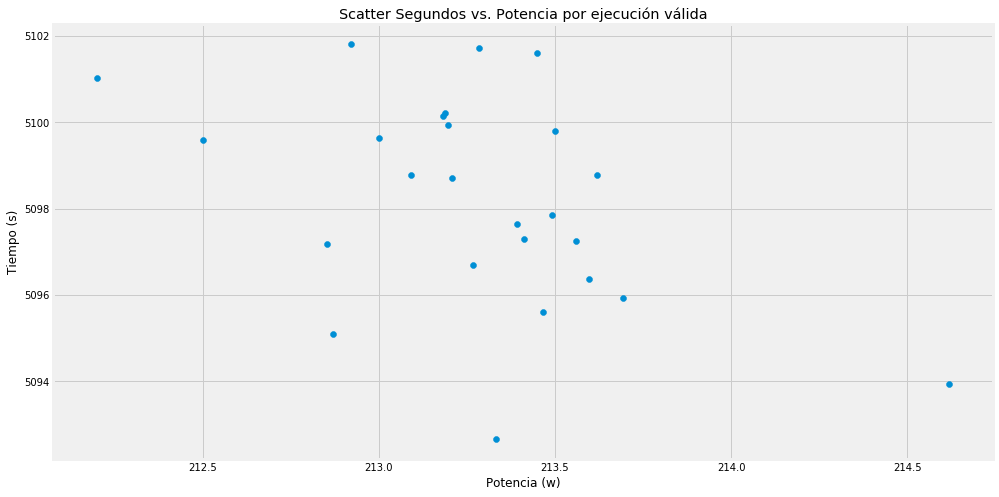

In [27]:
plt.figure(figsize = (15,8))
plt.scatter(ds['pwr'],ds['secs'])
plt.title('Scatter Segundos vs. Potencia por ejecución válida')
plt.xlabel('Potencia (w)')
plt.ylabel('Tiempo (s)')
plt.show()

En el scatter ya se ve con la misma potencia media tenemos distintos tiempos de finalización y viceversa

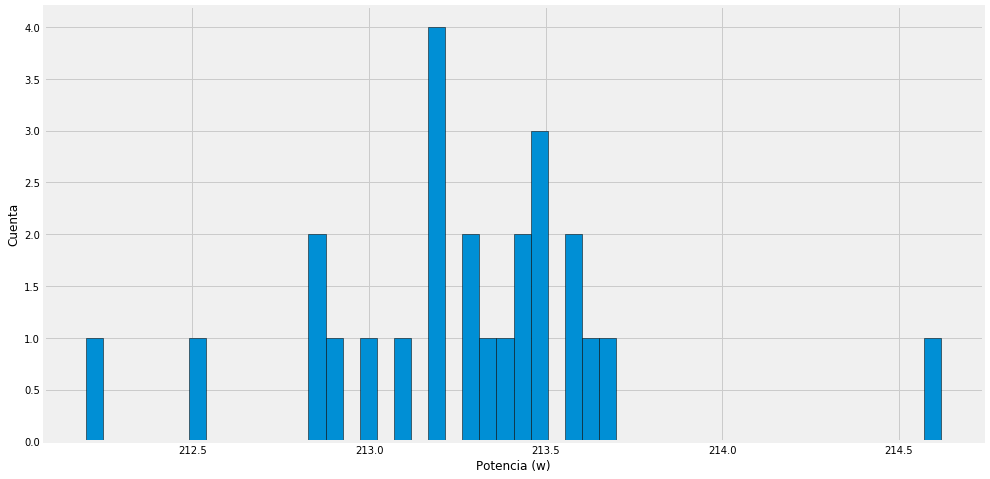

In [28]:
plt.figure(figsize = (15,8))
plt.hist(ds['pwr'],bins=50, edgecolor ='k')
plt.xlabel('Potencia (w)')
plt.ylabel('Cuenta')
plt.show()

Histograma de potencias validas para la simulación

In [29]:
#Pintamos el mejor resultado
a = ds.groupby(['intento'])['secs'].agg('sum').sort_values(ascending=True)
a[:1].max()

5092.6572265625

In [30]:
#Nos quedamos con los 50 mejores resultados para ser analizdos en Tableau
ganadores = pd.DataFrame(ds[ds['secs']<=a[:15].max()][['intento','list']])
ganadores

,intento,list
2,1500,"[[0, 218.9055330107737, 27.284435, 344.0415503..."
3,2162,"[[0, 230.42687685344598, 28.012642, 344.041550..."
4,2736,"[[0, 214.29699547370478, 26.993153, 344.041550..."
5,3357,"[[0, 230.42687685344598, 28.012642, 344.041550..."
6,3559,"[[0, 221.20980177930815, 27.430079, 344.041550..."
7,3841,"[[0, 225.81833931637706, 27.72136, 344.0415503..."
9,4596,"[[0, 221.20980177930815, 27.430079, 344.041550..."
10,5115,"[[0, 230.42687685344598, 28.012642, 344.041550..."
12,5982,"[[0, 221.20980177930815, 27.430079, 344.041550..."
13,6384,"[[0, 221.20980177930815, 27.430079, 344.041550..."


In [31]:
#Agregamos las características de cada tramo al df de ganadores y sacamos el resultado a Excel
for i in range(len(ganadores)):
    if i == 0:
        df_ganador = pd.DataFrame(ganadores.values[i][1])
        df_ganador.columns =["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]
        df_ganador['Intento'] = ganadores.values[i][0]
    else:
        df_aux = pd.DataFrame(ganadores.values[i][1])
        df_aux.columns =["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]
        df_aux['Intento'] = ganadores.values[i][0]
        df_ganador = df_ganador.append([df_aux])
        del df_aux
df_ganador.to_excel('res_sim_2vuelta.xlsx')
df_ganador.head()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,218.905533,27.284435,344.041550,45.393997,1.596116,3.492273,1500
1,1,197.179408,34.814007,13.567297,1.402949,-0.218832,1.574548,1500
2,2,200.664473,32.088795,168.993513,18.959162,0.371159,1.731397,1500
3,3,194.579999,33.890312,17.331806,1.841072,-0.067596,1.575208,1500
4,4,193.641979,33.321259,48.498332,5.239718,0.074144,3.407638,1500


In [32]:
df_ganador.describe()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
count,1260.00000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000
mean,41.50000,201.606502,33.702907,507.744281,60.674444,-0.047731,-0.587996,5557.666667
std,24.25662,34.467250,6.595411,689.876449,86.684257,1.809585,5.306655,2703.290868
min,0.00000,101.972071,17.630846,12.158278,1.296874,-4.645913,-9.954147,1500.000000
25%,20.75000,182.433723,31.700541,25.516494,2.830195,-0.565377,-4.099877,3357.000000
50%,41.50000,206.264302,33.783070,145.726222,16.087080,0.001432,-1.248373,5115.000000
75%,62.25000,224.801572,36.745007,784.964079,78.155336,0.363841,2.888754,7734.000000
max,83.00000,273.693264,49.150597,3454.663686,348.345062,4.950157,9.997376,10630.000000


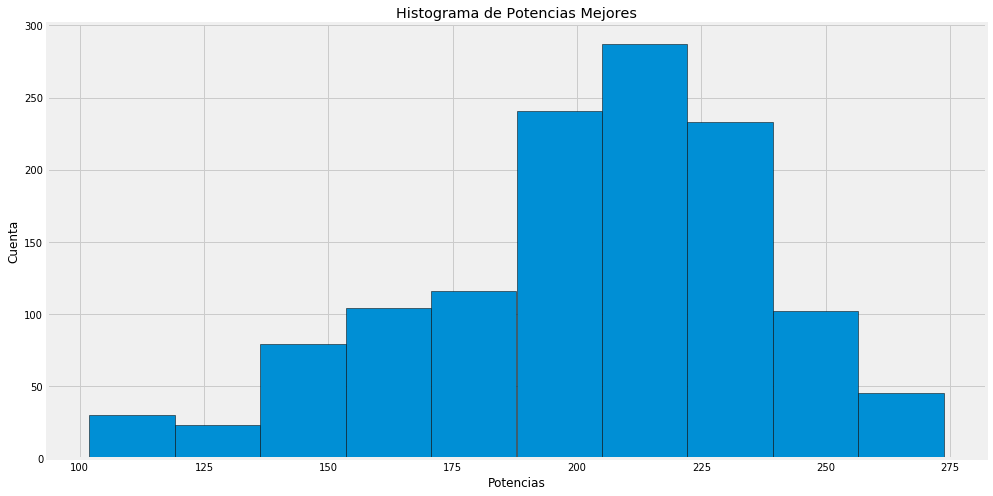

In [33]:
plt.figure(figsize = (15,8))
plt.hist(df_ganador['Potencia'], edgecolor ='k')
plt.title('Histograma de Potencias Mejores')
plt.xlabel('Potencias')
plt.ylabel('Cuenta')
plt.show()

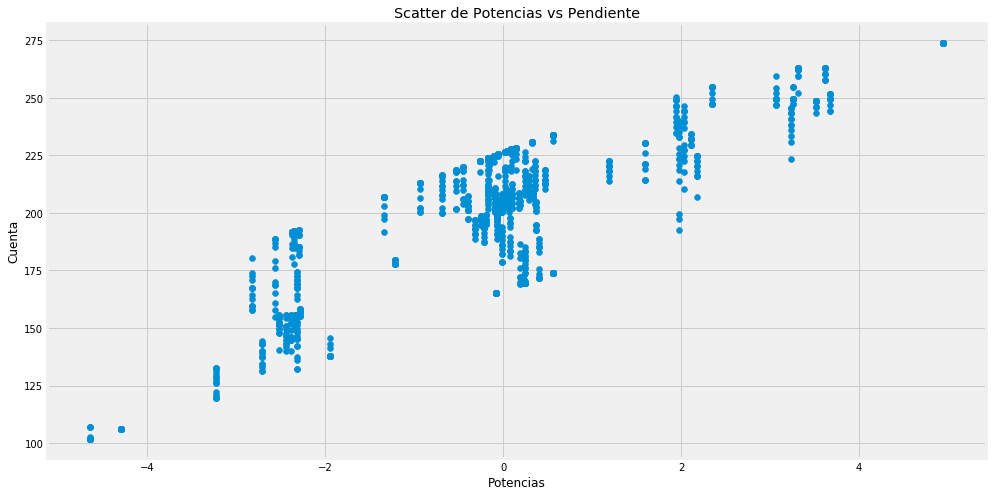

In [34]:
plt.figure(figsize = (15,8))
plt.scatter(df_ganador['Pendiente'],df_ganador['Potencia'])
plt.title('Scatter de Potencias vs Pendiente')
plt.xlabel('Potencias')
plt.ylabel('Cuenta')
plt.show()